# The First Circle: Previously On Nine Circles, Part Two 
## Logistic regression

<br/>
Jiří Fejlek

2025-12-05
<br/>

We continue our summary of regression methods with logistic regression. We will use the dataset obtained from <https://www.kaggle.com/datasets/dileep070/heart-disease-prediction-using-logistic-regression/data> based on the Framingham Heart Study <https://www.framinghamheartstudy.org>. The Framingham Heart Study is a long-term, ongoing cardiovascular cohort study of residents of Framingham, Massachusetts, that began in 1948 to identify factors contributing to cardiovascular diseases, including the effects of high blood pressure and smoking.

## Table of Contents

- [Cardiovascular Study on Residents of the Town of Framingham, Massachusetts](#framingham)
- [Complete Case Analysis](#complete-case)
    - [Model Fit and Examining Effects of Predictors](#fit-inference)
    - [Model Diagnostics](#diagnostics)
    - [Measures of Predictive Performance](#performance)
        - [Prediction Accuracy (percentage of correct predictions)](#accuracy)
        - [Specificity & Sensitivity, ROC curve](#roc)
        - [Strictly Proper Scoring Rules (logarithmic score and Brier score)](#scoring)
        - [Calibration](#calibration)
        - [Decision Curve Analysis](#dca)
    - [Model Validation](#validation)
- [Mean and Most-Frequent Imputation](#mean-imputation)
- [k-NN Imputation](#knn)
- [MissForrest Imputation](#missforrest)
- [Regression Imputation (via chained equation)](#mice)
- [References](#references)


## Cardiovascular Study on Residents of the Town of Framingham, Massachusetts <a class="anchor" id="framingham"></a>

The Framingham Heart Study contains the following information about 4238 individuals. Each individual was examined and then followed for 10 years for the outcome of developing coronary heart disease.

* **Sex** 
* **Age** - Age (at the time of examination)
* **Education** - Four levels: no high school, high school, college, and college graduate
* **Current Smoker** - Whether or not the subject was a  smoker (at the time of examination)
* **Cigs Per Day** - Cigarettes smoked on average in one day
* **BP Meds** - Whether or not the subject was on blood pressure medication 
* **Prevalent Stroke** - Whether or not the subject had previously had a stroke
* **Prevalent Hyp** - Whether or not the subject was hypertensive
* **Diabetes** - Whether or not the subject had diabetes
* **Tot Chol** -  Total cholesterol level
* **Sys BP** - Systolic blood pressure 
* **Dia BP** -  Diastolic blood pressure
* **BMI** - Body Mass Index
* **Glucose** - Glucose level 
* **TenYearCHD** -  Whether or not a coronary heart disease occurred in 10 years after examination


First, let us load the dataset.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import KFold

np.set_printoptions(legacy='1.25')

In [7]:
framingham = pd.read_csv('C:/Users/elini/Desktop/nine circles 2/framingham.csv')
framingham

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


In [6]:
framingham.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

We shorten the names of the predictors.

In [12]:
framingham = framingham.rename(columns={'male': 'Sex', 'age': 'Age', 'currentSmoker': 'Smoker', \
                                        'prevalentStroke': 'Stroke', 'prevalentHyp': 'Hyp', \
                                        'diabetes': 'Diab', 'TenYearCHD': 'TCHD', 'sysBP': 'SysP', \
                                        'diaBP': 'DiaP', 'heartRate': 'Hrate', 'cigsPerDay': 'Cig', \
                                        'totChol': 'Chol', 'BPMeds': 'Meds', 'education': 'Edu', \
                                        'glucose': 'Gluc'})

Next, we check whether any data is missing.

In [9]:
framingham.duplicated(keep = False).any(axis = None)

False

In [10]:
framingham.isna().any(axis = None)

True

<br/> Some values are indeed missing.

In [21]:
framingham.isna().any(axis = 1).sum()

582

In [11]:
framingham.isna().sum(axis = 0)

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

The fraction of rows with some missing values is 582/4238 ~ 0.14. This is a significantly greater value than 3%, which is a rule-of-thumb value for which it should not matter much how the observation with missing values is treated [[1](#1)]. Thus, we need to take some care with our analysis as far as the missing data is concerned.

Let us check the predictors.

In [23]:
framingham['Sex'].value_counts() # 0: female, 1:male

Sex
0    2419
1    1819
Name: count, dtype: int64

In [24]:
framingham['Edu'].value_counts()

Edu
1.0    1720
2.0    1253
3.0     687
4.0     473
Name: count, dtype: int64

In [25]:
framingham['Smoker'].value_counts()

Smoker
0    2144
1    2094
Name: count, dtype: int64

In [26]:
framingham['Meds'].value_counts()

Meds
0.0    4061
1.0     124
Name: count, dtype: int64

In [27]:
framingham['Stroke'].value_counts()

Stroke
0    4213
1      25
Name: count, dtype: int64

In [28]:
framingham['Hyp'].value_counts()

Hyp
0    2922
1    1316
Name: count, dtype: int64

In [29]:
framingham['Diab'].value_counts()

Diab
0    4129
1     109
Name: count, dtype: int64

Text(0.5, 0, 'DiaP')

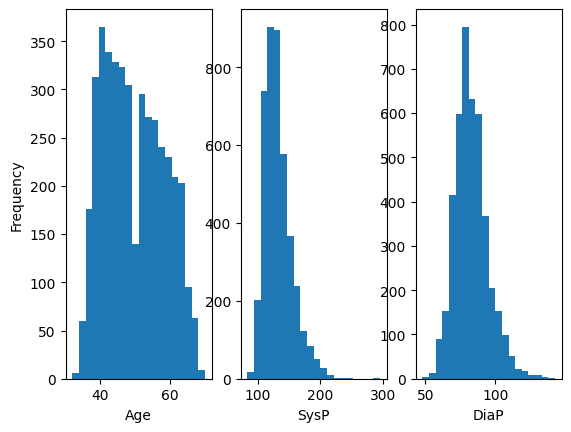

In [30]:
fig, axs = plt.subplots(1,3)
axs[0].hist(framingham['Age'], bins=20)
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')
axs[1].hist(framingham['SysP'], bins=20)  
axs[1].set_xlabel('SysP')    
axs[2].hist(framingham['DiaP'], bins=20)  
axs[2].set_xlabel('DiaP');    

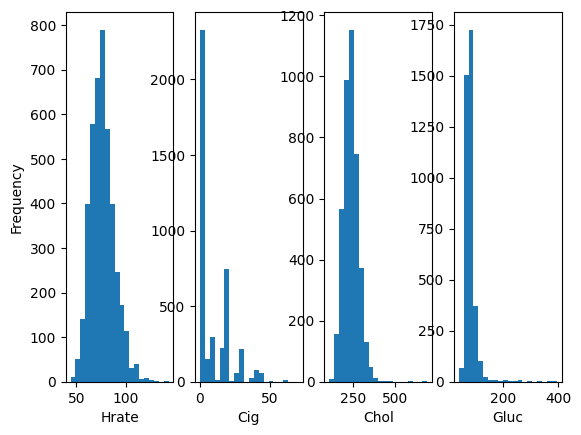

In [32]:
fig, axs = plt.subplots(1,4)
axs[0].hist(framingham['Hrate'], bins=20)
axs[0].set_xlabel('Hrate')
axs[0].set_ylabel('Frequency')
axs[1].hist(framingham['Cig'], bins=20)  
axs[1].set_xlabel('Cig')    
axs[2].hist(framingham['Chol'], bins=20)  
axs[2].set_xlabel('Chol')
axs[3].hist(framingham['Gluc'], bins=20)  
axs[3].set_xlabel('Gluc');

Overall, the values and their distributions seem reasonable. Some minima and maxima are pretty extreme, but none of these seem impossible to occur. Several factors, namely **BP Meds**, **Diabetes**, and especially  **Prevalent Stroke**, have a low number of cases, which could hurt the accuracy of estimates of their effect. Still, these predictors seem too important to be just ignored.   

We will remove **Current Smoker** from our model and keep just **Cigs Per Day** since no smoker reports that he/she smoke zero cigarettes per day on average. Thus, we opt to quantify the effect of smoking in our model using a more informative numerical predictor **Cigs Per Day.** Otherwise, we will consider all predictors for modeling.

In [35]:
((framingham['Smoker'] == 1) & (framingham['Cig'] == 0)).any()

False

## Complete Case Analysis <a class="anchor" id="complete-case"></a>

Before we proceed to model with the imputation of missing values, we will perform *complete case analysis* (listwise deletion) for future comparison with other approaches. We should remember that the inference based on complete case analysis is valid under the missing completely at random (MCAR) condition (the probability of missing is the same for all cases), i.e., complete case analysis under MCAR produces unbiased regression estimates [[2](#2)]. If this is not the case (missingness depends on the data or on some unobserved variables), then these estimates may be severely biased. Another disadvantage of complete-case analysis is that it can be wasteful with the data. On the other hand, a complete case analysis is very simple to perform.

In [33]:
framingham_complete = framingham.loc[~framingham.isna().any(axis = 1)].reset_index(drop=True)

Before we fit the data, let us check whether some variables are not too correlated.

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
ind = [*range(3),*range(4,15)]
VIF_dataframe = framingham_complete.iloc[:,ind].assign(const=1)

VIF_vals = [VIF(VIF_dataframe, i) 
        for i in range(0, VIF_dataframe.shape[1])]
VIF_vals = pd.DataFrame({'VIF':VIF_vals},index=VIF_dataframe.columns)
VIF_vals

,VIF
Sex,1.201334
Age,1.353394
Edu,1.055094
Cig,1.201720
Meds,1.111183
Stroke,1.017398
Hyp,2.050781
Diab,1.615851
Chol,1.116276
SysP,3.766397


### Model Fit and Examining Effects of Predictors <a class="anchor" id="fit-inference"></a>

Since we are dealing with the binary response, we will be fitting a logistic regression model $\mathrm{log} \frac{p}{1-p} = X\beta$, where $p$ is the probability of the response 1 and $X$ is the model matrix of our predictors and $\beta$ are the parameters. When selecting our model matrix, we should consider the *effective sample size*. For binary response, the effective sample size is the number of observations for the less represented response; in our case, it is 557 (even though we technically have 3656 observations). Thus, our data reasonably support approximately 557/10 ~ 56 to 557/20 ~ 28 parameters [[1](#1)].

In [37]:
(framingham['TCHD'] == 0).sum()

3594

In [38]:
(framingham['TCHD'] == 1).sum()

644

Since we have only 14 predictors, we can include some nonlinearities and interactions in the model.  We will consider cubic splines with 3 DOF for all numerical predictors. We will also consider linear interactions of age and sex with risk factors (i.e., the whole model has 53 parameters).

In [43]:
lr_full = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3)  + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
lr_full_fit = lr_full.fit(disp=0)                              
print(lr_full_fit.summary())

                           Logit Regression Results                           
Dep. Variable:                   TCHD   No. Observations:                 3656
Model:                          Logit   Df Residuals:                     3603
Method:                           MLE   Df Model:                           52
Date:                Wed, 03 Dec 2025   Pseudo R-squ.:                  0.1342
Time:                        18:14:07   Log-Likelihood:                -1350.9
converged:                       True   LL-Null:                       -1560.3
Covariance Type:            nonrobust   LLR p-value:                 8.903e-59
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.9624      1.514     -1.296      0.195      -4.929       1.004
C(Edu, Poly).Linear       -0.0179      0.118     -0.151      0.880      -0.250       0.214
C(Ed

In [40]:
len(lr_full_fit.params)

53

To test the significance of a given variable (e.g., **Cigs per day**) on the probability of developing **TCHD**, we can use a likelihood ratio test.

In [44]:
# likelihood ratio tests
from scipy.stats.distributions import chi2   

LR_test = pd.DataFrame(index=['Sex','Age','Edu','Cig','Meds','Stroke','Hyp','Diab','Chol','SysP','DiabP','BMI','Hrate','Gluc'], \
                       columns = ['Deviance','DoF','P-value'])


lr_no_sex = smf.logit(formula='TCHD ~ bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
                     
LR_test.iloc[0,0] = 2*(lr_full_fit.llf-lr_no_sex.fit(disp=0).llf)
LR_test.iloc[0,1] = (lr_full.df_model - lr_no_sex.df_model)
LR_test.iloc[0,2] = 1 - chi2.cdf(LR_test.iloc[0,0],LR_test.iloc[0,1])
                          

lr_no_age = smf.logit(formula='TCHD ~ Sex + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
LR_test.iloc[1,0] = 2*(lr_full_fit.llf-lr_no_age.fit(disp=0).llf)
LR_test.iloc[1,1] = (lr_full.df_model - lr_no_age.df_model)
LR_test.iloc[1,2] = 1 - chi2.cdf(LR_test.iloc[1,0],LR_test.iloc[1,1])


lr_no_edu = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
LR_test.iloc[2,0] = 2*(lr_full_fit.llf-lr_no_edu.fit(disp=0).llf)
LR_test.iloc[2,1] = (lr_full.df_model - lr_no_edu.df_model)
LR_test.iloc[2,2] = 1 - chi2.cdf(LR_test.iloc[2,0],LR_test.iloc[2,1])
                
      
lr_no_cig = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)                     
LR_test.iloc[3,0] = 2*(lr_full_fit.llf-lr_no_cig.fit(disp=0).llf)
LR_test.iloc[3,1] = (lr_full.df_model - lr_no_cig.df_model)
LR_test.iloc[3,2] = 1 - chi2.cdf(LR_test.iloc[3,0],LR_test.iloc[3,1])


lr_no_meds = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
LR_test.iloc[4,0] = 2*(lr_full_fit.llf-lr_no_meds.fit(disp=0).llf)
LR_test.iloc[4,1] = (lr_full.df_model - lr_no_meds.df_model)
LR_test.iloc[4,2] = 1 - chi2.cdf(LR_test.iloc[4,0],LR_test.iloc[4,1])


lr_no_stroke = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
LR_test.iloc[5,0] = 2*(lr_full_fit.llf-lr_no_stroke.fit(disp=0).llf)
LR_test.iloc[5,1] = (lr_full.df_model - lr_no_stroke.df_model)
LR_test.iloc[5,2] = 1 - chi2.cdf(LR_test.iloc[5,0],LR_test.iloc[5,1])


lr_no_hyp = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
LR_test.iloc[6,0] = 2*(lr_full_fit.llf-lr_no_hyp.fit(disp=0).llf)
LR_test.iloc[6,1] = (lr_full.df_model - lr_no_hyp.df_model)
LR_test.iloc[6,2] = 1 - chi2.cdf(LR_test.iloc[6,0],LR_test.iloc[6,1])


lr_no_diab = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
LR_test.iloc[7,0] = 2*(lr_full_fit.llf-lr_no_diab.fit(disp=0).llf)
LR_test.iloc[7,1] = (lr_full.df_model - lr_no_diab.df_model)
LR_test.iloc[7,2] = 1 - chi2.cdf(LR_test.iloc[7,0],LR_test.iloc[7,1])


lr_no_chol = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
LR_test.iloc[8,0] = 2*(lr_full_fit.llf-lr_no_chol.fit(disp=0).llf)
LR_test.iloc[8,1] = (lr_full.df_model - lr_no_chol.df_model)
LR_test.iloc[8,2] = 1 - chi2.cdf(LR_test.iloc[8,0],LR_test.iloc[8,1]) 


lr_no_sysp = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)                   
LR_test.iloc[9,0] = 2*(lr_full_fit.llf-lr_no_sysp.fit(disp=0).llf)
LR_test.iloc[9,1] = (lr_full.df_model - lr_no_sysp.df_model)
LR_test.iloc[9,2] = 1 - chi2.cdf(LR_test.iloc[9,0],LR_test.iloc[9,1])   


lr_no_diap = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + BMI + Hrate + Gluc)', data=framingham_complete)
LR_test.iloc[10,0] = 2*(lr_full_fit.llf-lr_no_diap.fit(disp=0).llf)
LR_test.iloc[10,1] = (lr_full.df_model - lr_no_diap.df_model)
LR_test.iloc[10,2] = 1 - chi2.cdf(LR_test.iloc[10,0],LR_test.iloc[10,1])   
                  

lr_no_bmi = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + Hrate + Gluc)', data=framingham_complete)                     
LR_test.iloc[11,0] = 2*(lr_full_fit.llf-lr_no_bmi.fit(disp=0).llf)
LR_test.iloc[11,1] = (lr_full.df_model - lr_no_bmi.df_model)
LR_test.iloc[11,2] = 1 - chi2.cdf(LR_test.iloc[11,0],LR_test.iloc[11,1]) 


lr_no_hrate = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Gluc)', data=framingham_complete)
LR_test.iloc[12,0] = 2*(lr_full_fit.llf-lr_no_hrate.fit(disp=0).llf)
LR_test.iloc[12,1] = (lr_full.df_model - lr_no_hrate.df_model)
LR_test.iloc[12,2] = 1 - chi2.cdf(LR_test.iloc[12,0],LR_test.iloc[12,1])                      


lr_no_gluc = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate)', data=framingham_complete)
LR_test.iloc[13,0] = 2*(lr_full_fit.llf-lr_no_gluc.fit(disp=0).llf)
LR_test.iloc[13,1] = (lr_full.df_model - lr_no_gluc.df_model)
LR_test.iloc[13,2] = 1 - chi2.cdf(LR_test.iloc[13,0],LR_test.iloc[13,1])                      
                     
LR_test

,Deviance,DoF,P-value
Sex,32.14357,11.0,0.000723
Age,106.658236,13.0,0.0
Edu,2.941309,3.0,0.400763
Cig,24.693428,5.0,0.00016
Meds,0.36142,1.0,0.547719
Stroke,2.827239,3.0,0.419036
Hyp,6.407344,3.0,0.093389
Diab,3.713417,3.0,0.294119
Chol,15.402675,5.0,0.008773
SysP,17.607744,5.0,0.00348


We observe that **Sex**, **Age**, **Cig**, **Chol**, **SysP**, **DiabP**, and **Gluc** are significant risk factors in the model. Let us examine the predicted marginal effects (along with their confidence intervals) based on our model. We will plot the effects for both sexes at the median value of the remaining predictors.

In [45]:
median_values = framingham_complete.median();

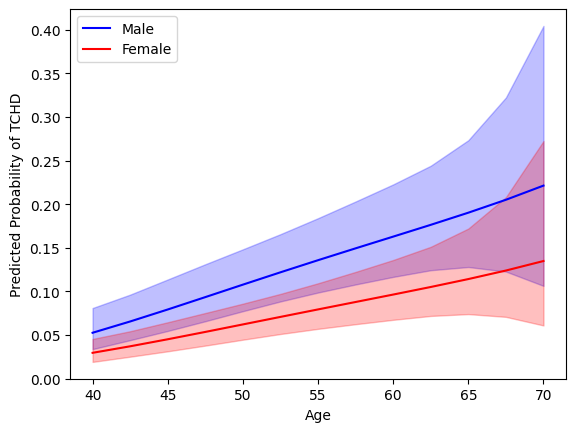

In [48]:
# age & sex
age_seq = np.array([*range(80,145,5)])/2

male_plot = framingham_complete.copy().iloc[range(len(age_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Age'] = age_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


plt.fill_between(male_plot['Age'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
plt.plot(male_plot['Age'],predict_male['predicted'], label='Male',color = 'blue')
plt.fill_between(female_plot['Age'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
plt.plot(female_plot['Age'],predict_female['predicted'], label='Female',color = 'red')
plt.xlabel('Age')
plt.ylabel('Predicted Probability of TCHD')
plt.legend();

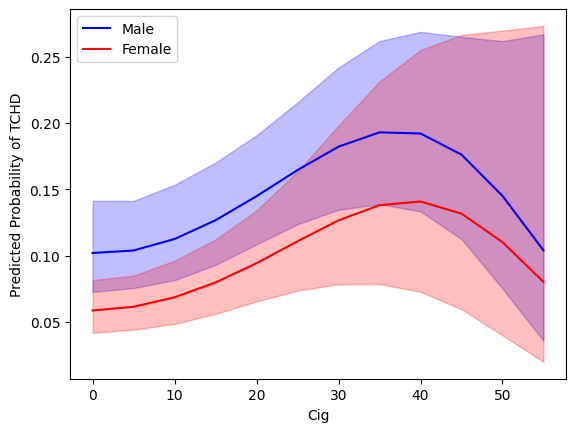

In [62]:
# cig & sex
cig_seq = np.array([*range(0,60,5)])

male_plot = framingham_complete.copy().iloc[range(len(cig_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Cig'] = cig_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


plt.fill_between(male_plot['Cig'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
plt.plot(male_plot['Cig'],predict_male['predicted'], label='Male',color = 'blue')
plt.fill_between(female_plot['Cig'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
plt.plot(female_plot['Cig'],predict_female['predicted'], label='Female',color = 'red')
plt.xlabel('Cig')
plt.ylabel('Predicted Probability of TCHD')
plt.legend();

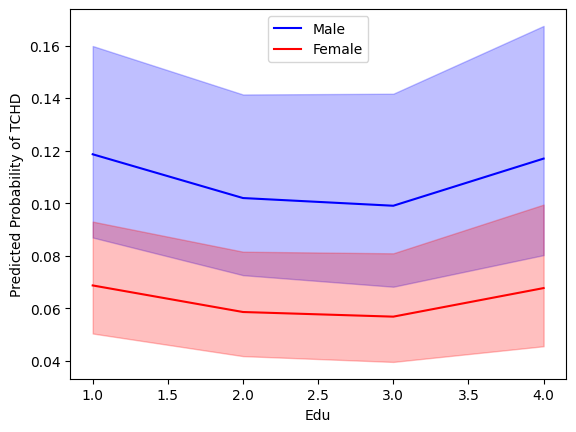

In [54]:
# edu & sex
edu_seq = [1,2,3,4]

male_plot = framingham_complete.copy().iloc[range(len(edu_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Edu'] = edu_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


plt.fill_between(male_plot['Edu'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
plt.plot(male_plot['Edu'],predict_male['predicted'], label='Male',color = 'blue')
plt.fill_between(female_plot['Edu'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
plt.plot(female_plot['Edu'],predict_female['predicted'], label='Female',color = 'red')
plt.xlabel('Edu')
plt.ylabel('Predicted Probability of TCHD')
plt.legend();

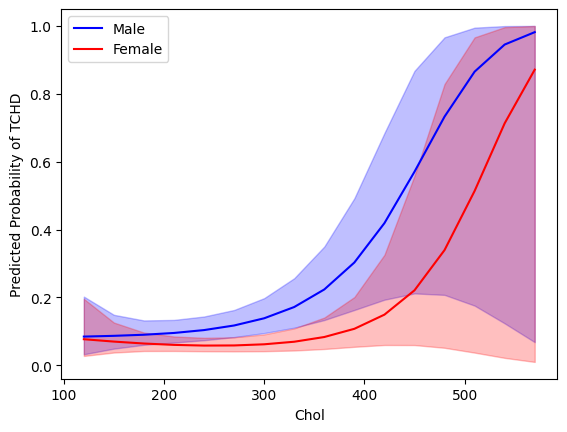

In [57]:
# chol & sex
chol_seq = np.array([*range(120,600,30)])

male_plot = framingham_complete.copy().iloc[range(len(chol_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Chol'] = chol_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


plt.fill_between(male_plot['Chol'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
plt.plot(male_plot['Chol'],predict_male['predicted'], label='Male',color = 'blue')
plt.fill_between(female_plot['Chol'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
plt.plot(female_plot['Chol'],predict_female['predicted'], label='Female',color = 'red')
plt.xlabel('Chol')
plt.ylabel('Predicted Probability of TCHD')
plt.legend();

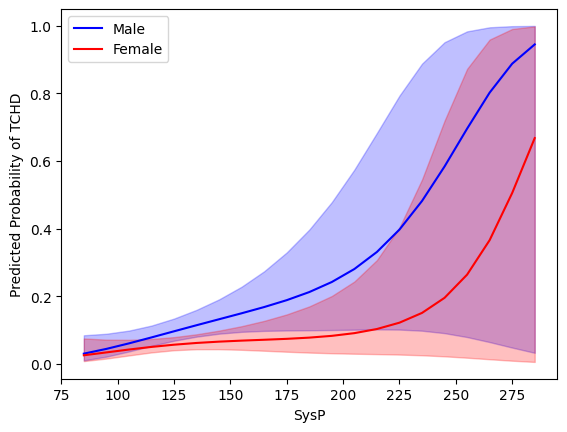

In [85]:
# sysp & sex
sysp_seq = np.array([*range(85,295,10)])

male_plot = framingham_complete.copy().iloc[range(len(sysp_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['SysP'] = sysp_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


plt.fill_between(male_plot['SysP'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
plt.plot(male_plot['SysP'],predict_male['predicted'], label='Male',color = 'blue')
plt.fill_between(female_plot['SysP'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
plt.plot(female_plot['SysP'],predict_female['predicted'], label='Female',color = 'red')
plt.xlabel('SysP')
plt.ylabel('Predicted Probability of TCHD')
plt.legend();

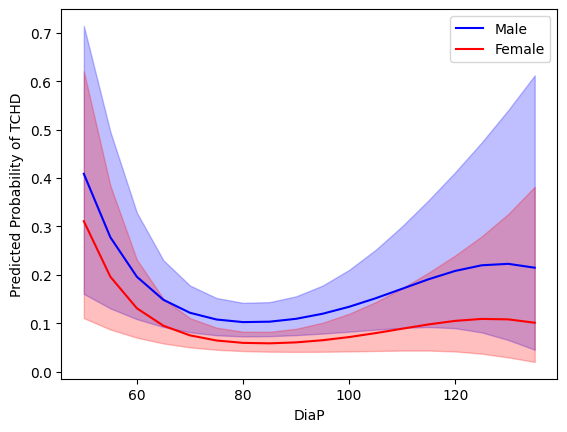

In [60]:
# diap & sex
diap_seq = np.array([*range(50,140,5)])

male_plot = framingham_complete.copy().iloc[range(len(diap_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['DiaP'] = diap_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


plt.fill_between(male_plot['DiaP'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
plt.plot(male_plot['DiaP'],predict_male['predicted'], label='Male',color = 'blue')
plt.fill_between(female_plot['DiaP'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
plt.plot(female_plot['DiaP'],predict_female['predicted'], label='Female',color = 'red')
plt.xlabel('DiaP')
plt.ylabel('Predicted Probability of TCHD')
plt.legend();

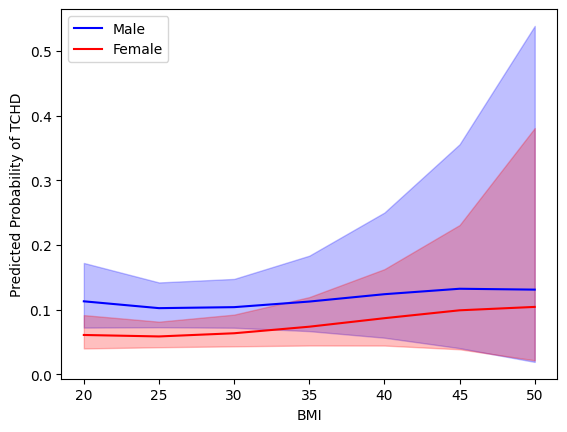

In [63]:
# BMI & sex
bmi_seq = np.array([*range(20,55,5)])

male_plot = framingham_complete.copy().iloc[range(len(bmi_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['BMI'] = bmi_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


plt.fill_between(male_plot['BMI'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
plt.plot(male_plot['BMI'],predict_male['predicted'], label='Male',color = 'blue')
plt.fill_between(female_plot['BMI'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
plt.plot(female_plot['BMI'],predict_female['predicted'], label='Female',color = 'red')
plt.xlabel('BMI')
plt.ylabel('Predicted Probability of TCHD')
plt.legend();

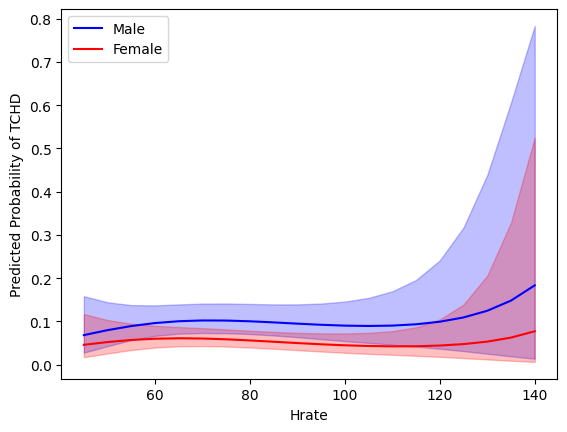

In [66]:
# Hrate & sex
hrate_seq = np.array([*range(45,145,5)])

male_plot = framingham_complete.copy().iloc[range(len(hrate_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Hrate'] = hrate_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


plt.fill_between(male_plot['Hrate'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
plt.plot(male_plot['Hrate'],predict_male['predicted'], label='Male',color = 'blue')
plt.fill_between(female_plot['Hrate'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
plt.plot(female_plot['Hrate'],predict_female['predicted'], label='Female',color = 'red')
plt.xlabel('Hrate')
plt.ylabel('Predicted Probability of TCHD')
plt.legend();

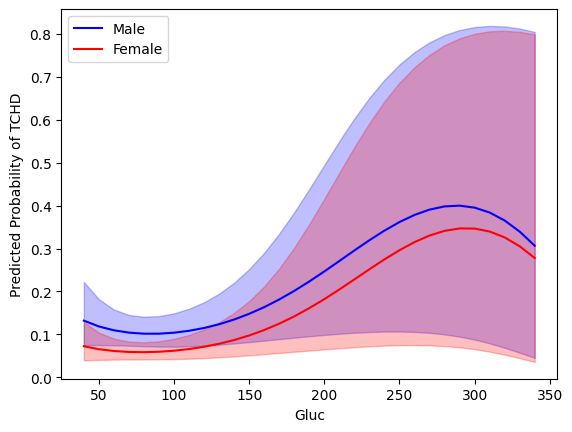

In [65]:
# Gluc & sex
gluc_seq = np.array([*range(40,350,10)])

male_plot = framingham_complete.copy().iloc[range(len(gluc_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Gluc'] = gluc_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


plt.fill_between(male_plot['Gluc'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
plt.plot(male_plot['Gluc'],predict_male['predicted'], label='Male',color = 'blue')
plt.fill_between(female_plot['Gluc'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
plt.plot(female_plot['Gluc'],predict_female['predicted'], label='Female',color = 'red')
plt.xlabel('Gluc')
plt.ylabel('Predicted Probability of TCHD')
plt.legend();

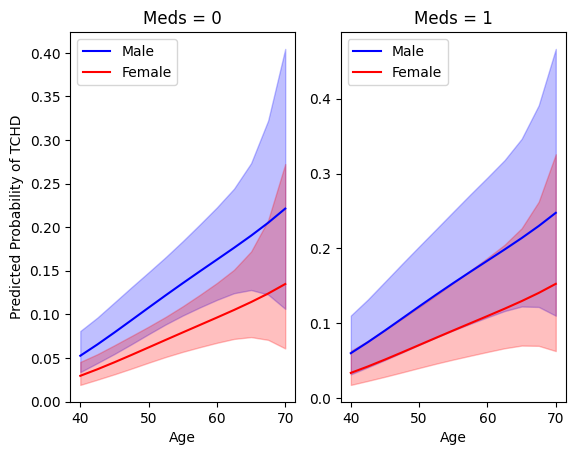

In [79]:
# age & sex & meds 
age_seq = np.array([*range(80,145,5)])/2

male_plot = framingham_complete.copy().iloc[range(len(age_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Age'] = age_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


fig, axs = plt.subplots(1,2)
axs[0].plot(male_plot['Age'],predict_male['predicted'], label='Male',color = 'blue')
axs[0].plot(female_plot['Age'],predict_female['predicted'], label='Female',color = 'red')
axs[0].fill_between(male_plot['Age'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
axs[0].fill_between(female_plot['Age'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Predicted Probability of TCHD')
axs[0].set_title('Meds = 0')
axs[0].legend()

male_plot['Meds'] = 1
female_plot['Meds'] = 1
predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)

axs[1].plot(male_plot['Age'],predict_male['predicted'], label='Male',color = 'blue')
axs[1].plot(female_plot['Age'],predict_female['predicted'], label='Female',color = 'red')
axs[1].fill_between(male_plot['Age'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
axs[1].fill_between(female_plot['Age'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red');
axs[1].set_xlabel('Age')
axs[1].set_title('Meds = 1')
axs[1].legend();

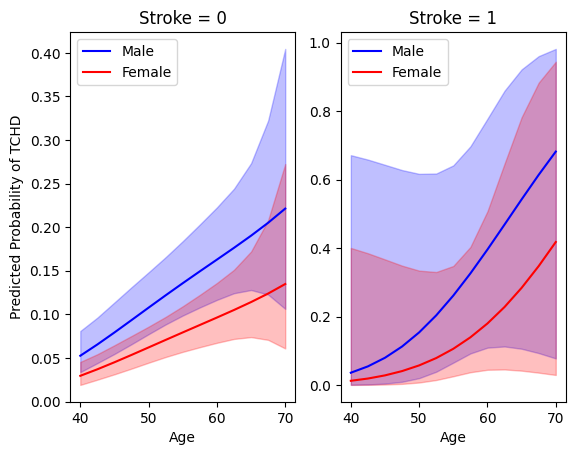

In [80]:
# age & sex & stroke 
age_seq = np.array([*range(80,145,5)])/2

male_plot = framingham_complete.copy().iloc[range(len(age_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Age'] = age_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


fig, axs = plt.subplots(1,2)
axs[0].plot(male_plot['Age'],predict_male['predicted'], label='Male',color = 'blue')
axs[0].plot(female_plot['Age'],predict_female['predicted'], label='Female',color = 'red')
axs[0].fill_between(male_plot['Age'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
axs[0].fill_between(female_plot['Age'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Predicted Probability of TCHD')
axs[0].set_title('Stroke = 0')
axs[0].legend()

male_plot['Stroke'] = 1
female_plot['Stroke'] = 1
predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)

axs[1].plot(male_plot['Age'],predict_male['predicted'], label='Male',color = 'blue')
axs[1].plot(female_plot['Age'],predict_female['predicted'], label='Female',color = 'red')
axs[1].fill_between(male_plot['Age'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
axs[1].fill_between(female_plot['Age'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red');
axs[1].set_xlabel('Age')
axs[1].set_title('Stroke = 1')
axs[1].legend()

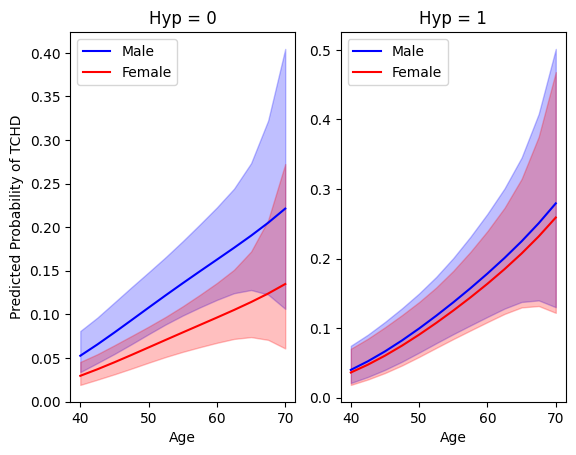

In [81]:
# age & sex & hyp 
age_seq = np.array([*range(80,145,5)])/2

male_plot = framingham_complete.copy().iloc[range(len(age_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Age'] = age_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


fig, axs = plt.subplots(1,2)
axs[0].plot(male_plot['Age'],predict_male['predicted'], label='Male',color = 'blue')
axs[0].plot(female_plot['Age'],predict_female['predicted'], label='Female',color = 'red')
axs[0].fill_between(male_plot['Age'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
axs[0].fill_between(female_plot['Age'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Predicted Probability of TCHD')
axs[0].set_title('Hyp = 0')
axs[0].legend()

male_plot['Hyp'] = 1
female_plot['Hyp'] = 1
predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)

axs[1].plot(male_plot['Age'],predict_male['predicted'], label='Male',color = 'blue')
axs[1].plot(female_plot['Age'],predict_female['predicted'], label='Female',color = 'red')
axs[1].fill_between(male_plot['Age'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
axs[1].fill_between(female_plot['Age'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red');
axs[1].set_xlabel('Age')
axs[1].set_title('Hyp = 1')
axs[1].legend();


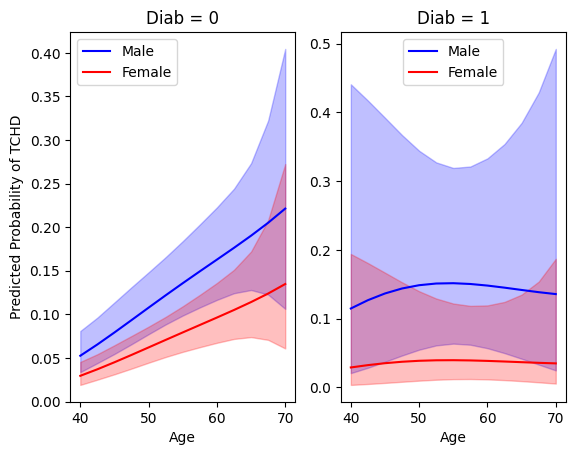

In [84]:
# age & sex & diab 
age_seq = np.array([*range(80,145,5)])/2

male_plot = framingham_complete.copy().iloc[range(len(age_seq)),:]
male_plot.iloc[:] = median_values
male_plot['Sex'] = 1
male_plot['Age'] = age_seq

female_plot = male_plot.copy()
female_plot['Sex'] = 0

predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)


fig, axs = plt.subplots(1,2)
axs[0].plot(male_plot['Age'],predict_male['predicted'], label='Male',color = 'blue')
axs[0].plot(female_plot['Age'],predict_female['predicted'], label='Female',color = 'red')
axs[0].fill_between(male_plot['Age'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
axs[0].fill_between(female_plot['Age'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Predicted Probability of TCHD')
axs[0].set_title('Diab = 0')
axs[0].legend()

male_plot['Diab'] = 1
female_plot['Diab'] = 1
predict_male = lr_full.fit(disp=0).get_prediction(male_plot).summary_frame(alpha=0.05)
predict_female = lr_full.fit(disp=0).get_prediction(female_plot).summary_frame(alpha=0.05)

axs[1].plot(male_plot['Age'],predict_male['predicted'], label='Male',color = 'blue')
axs[1].plot(female_plot['Age'],predict_female['predicted'], label='Female',color = 'red')
axs[1].fill_between(male_plot['Age'], predict_male['ci_upper'],\
                 predict_male['ci_lower'], alpha=.25,color = 'blue')
axs[1].fill_between(female_plot['Age'], predict_female['ci_upper'],\
                 predict_female['ci_lower'], alpha=.25,color = 'red');
axs[1].set_xlabel('Age')
axs[1].set_title('Diab = 1')
axs[1].legend();

Looking at the plots, we can notice that **Sex**, **Age**, **Cig**, **Chol**,  **SysP**,  **DiaP**, and **Gluc**  (predictors that were 'significant') seem to have a noticeable effect on the probability of TCHD. Interestingly enough, **DiaP** is the only numerical predictor that appears to have a strong nonlinear effect (nonlinearity of the effect of **Cig** seems to be caused by the lack of observations for **Cig** > 50; in our R implementation, where we used *restricted* cubic splines, the effect of **Cig** is estimated as monotonically increasing ).

Factors **Stroke** and **Diab** appear to have an effect, but the prediction uncertainty is too high (probably due to the low number of cases, as we discussed earlier). Variables **Edu**, **Meds**, **Hyp**, **BMI**, and **Hrate** seem to have very little effect.

Next, let us check the significance of the interactions.

In [87]:
# test interactions
lr_no_inter = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3)', \
                     data=framingham_complete)

1 - chi2.cdf(2*(lr_full_fit.llf-lr_no_inter.fit(disp=0).llf),(lr_full.df_model - lr_no_inter.df_model))

0.527900655708825

Interactions do not seem significant in the model. Let us have a look at the nonlinear terms. 

In [88]:
# test nonlinearities
lr_lin = smf.logit(formula='TCHD ~ Sex + Age + C(Edu, Poly) + Cig + Meds + Stroke + Hyp + Diab + Chol + \
                     SysP + DiaP + BMI + Hrate + Gluc + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)

1 - chi2.cdf(2*(lr_full_fit.llf-lr_lin.fit(disp=0).llf),(lr_full.df_model - lr_lin.df_model))

0.004021774649243026

 The model's nonlinear termsl are significant. Let us determine for which variable it is.

In [89]:
LR_test2 = pd.DataFrame(index=['Age','Cig','Chol','SysP','DiabP','BMI','Hrate','Gluc'], \
                       columns = ['Deviance','DoF','P-value'])


lr_lin_age = smf.logit(formula='TCHD ~ Sex + Age + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
                     
LR_test2.iloc[0,0] = 2*(lr_full_fit.llf-lr_lin_age.fit(disp=0).llf)
LR_test2.iloc[0,1] = (lr_full.df_model - lr_lin_age.df_model)
LR_test2.iloc[0,2] = 1 - chi2.cdf(LR_test2.iloc[0,0],LR_test2.iloc[0,1])


lr_lin_cig = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + Cig + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
                     
LR_test2.iloc[1,0] = 2*(lr_full_fit.llf-lr_lin_cig.fit(disp=0).llf)
LR_test2.iloc[1,1] = (lr_full.df_model - lr_lin_cig.df_model)
LR_test2.iloc[1,2] = 1 - chi2.cdf(LR_test2.iloc[1,0],LR_test2.iloc[1,1])



lr_lin_chol = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + Chol + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
                     
LR_test2.iloc[2,0] = 2*(lr_full_fit.llf-lr_lin_chol.fit(disp=0).llf)
LR_test2.iloc[2,1] = (lr_full.df_model - lr_lin_chol.df_model)
LR_test2.iloc[2,2] = 1 - chi2.cdf(LR_test2.iloc[2,0],LR_test2.iloc[2,1])


lr_lin_sysp = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     SysP + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
                     
LR_test2.iloc[3,0] = 2*(lr_full_fit.llf-lr_lin_sysp.fit(disp=0).llf)
LR_test2.iloc[3,1] = (lr_full.df_model - lr_lin_sysp.df_model)
LR_test2.iloc[3,2] = 1 - chi2.cdf(LR_test2.iloc[3,0],LR_test2.iloc[3,1])


lr_lin_diap = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + DiaP + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
                     
LR_test2.iloc[4,0] = 2*(lr_full_fit.llf-lr_lin_diap.fit(disp=0).llf)
LR_test2.iloc[4,1] = (lr_full.df_model - lr_lin_diap.df_model)
LR_test2.iloc[4,2] = 1 - chi2.cdf(LR_test2.iloc[4,0],LR_test2.iloc[4,1])



lr_lin_bmi = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + BMI + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
                     
LR_test2.iloc[5,0] = 2*(lr_full_fit.llf-lr_lin_bmi.fit(disp=0).llf)
LR_test2.iloc[5,1] = (lr_full.df_model - lr_lin_bmi.df_model)
LR_test2.iloc[5,2] = 1 - chi2.cdf(LR_test2.iloc[5,0],LR_test2.iloc[5,1])


lr_lin_hrate = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + Hrate + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
                     
LR_test2.iloc[6,0] = 2*(lr_full_fit.llf-lr_lin_hrate.fit(disp=0).llf)
LR_test2.iloc[6,1] = (lr_full.df_model - lr_lin_hrate.df_model)
LR_test2.iloc[6,2] = 1 - chi2.cdf(LR_test2.iloc[6,0],LR_test2.iloc[6,1])


lr_lin_gluc = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + Gluc + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_complete)
                     
LR_test2.iloc[7,0] = 2*(lr_full_fit.llf-lr_lin_gluc.fit(disp=0).llf)
LR_test2.iloc[7,1] = (lr_full.df_model - lr_lin_gluc.df_model)
LR_test2.iloc[7,2] = 1 - chi2.cdf(LR_test2.iloc[7,0],LR_test2.iloc[7,1])


LR_test2

,Deviance,DoF,P-value
Age,2.447749,2.0,0.294088
Cig,4.367284,2.0,0.112631
Chol,6.652814,2.0,0.035922
SysP,1.783007,2.0,0.410039
DiabP,11.663551,2.0,0.002933
BMI,0.929204,2.0,0.628385
Hrate,1.120257,2.0,0.571136
Gluc,4.585019,2.0,0.101013


Notably, it is the effect of **DiaP** which has a highly nonlinear dependence that seems to be significant. The 'J-shaped' dependence of the probability of developing heart disease (probability seems to increase at both low and high levels of diastolic pressure) is a known pattern observed in medical data. However, nowadays, the consensus is that the shape is a result of confounding and reverse causation (i.e., low blood pressure can indicate a high-risk state caused by other comorbidities), and it is highly unlikely to reflect a causal process [[3](#3)].

### Model Diagnostics <a class="anchor" id="diagnostics"></a>

Logistic regression of a binary response does not have distributional assumptions (we directly model the probability of an event $\mathrm{ln} \frac{p}{1-p} = X\beta$); hence, bias in our estimates will be connected to model misspecifications, such as omitted variable bias or the choice of the link function (which is in our case *logit*: $\mathrm{logit} (p) = \mathrm{ln} \frac{p}{1-p}$). 

An interesting fact about logistic regression is that omitted variable bias is caused by both missing predictors correlated with $X$ (as in linear regression) but also by uncorrelated omitted variables (unlike linear regression) [[4](#4)]. However, this second source of bias is always downwards (i.e., other effects will tend to look smaller than they actually are).

A standard method for assessing model misspecification in linear regression is to analyze residuals. However, plain residual plots are much less helpful in binary regression. 

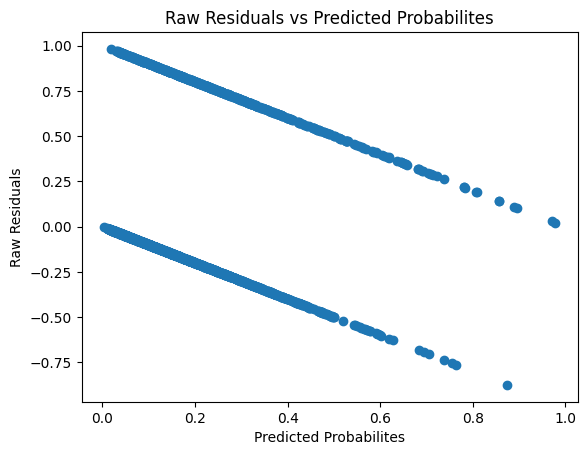

In [91]:
# raw residuals
plt.scatter(lr_full_fit.predict(), framingham_complete['TCHD'] - lr_full_fit.predict())
plt.title('Raw Residuals vs Predicted Probabilites')
plt.xlabel('Predicted Probabilites')
plt.ylabel('Raw Residuals');

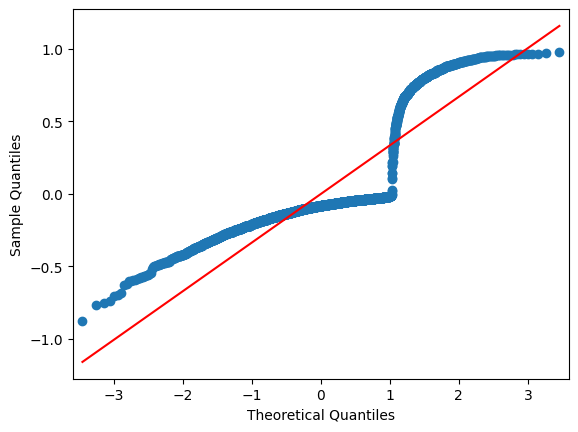

In [92]:
sm.qqplot( framingham_complete['TCHD'] - lr_full_fit.predict(), line='s');

Here, we plotted so-called *raw residuals* (observed outcomes minus predicted probabilities of outcomes) vs. predicted probabilities. These residuals have values in the interval [-1,1] that are quite apparently not normally distributed (and they cannot be, since apart from being bounded to [-1,1], they are inherently heteroskedastic, since the variance of binary outcome is $p(1-p)$). 

The *Pearson residuals* (raw residuals divided by their expected deviance) are as follows.

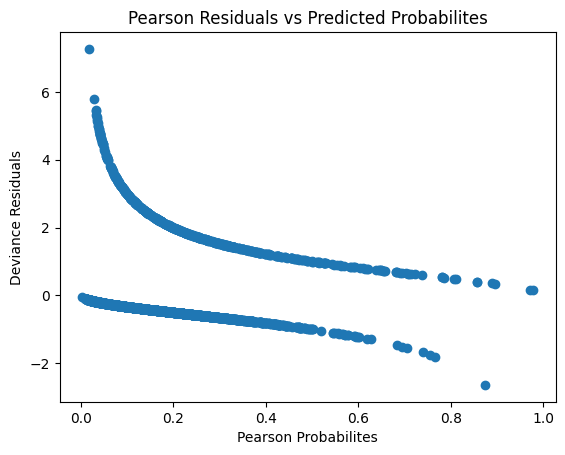

In [93]:
# Pearson residuals
pearson = pd.DataFrame(index = [*range(len(lr_full_fit.predict() ))], columns= ['Pearson'])
pearson['Pearson'] = ((framingham_complete['TCHD'] - \
                      lr_full_fit.predict())/np.sqrt(lr_full_fit.predict() * (1-lr_full_fit.predict())))
    
plt.scatter(lr_full_fit.predict(), pearson['Pearson'])
plt.title('Pearson Residuals vs Predicted Probabilites')
plt.xlabel('Pearson Probabilites')
plt.ylabel('Deviance Residuals');

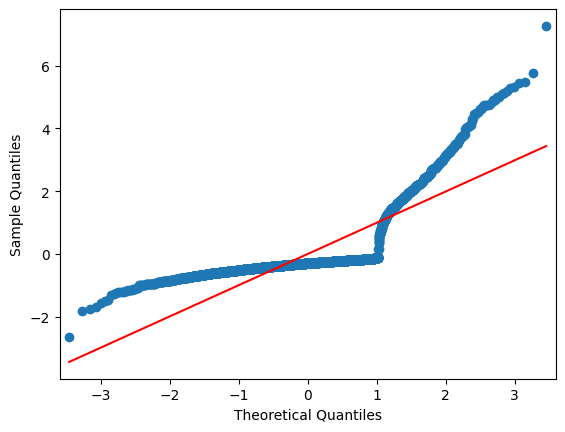

In [94]:
sm.qqplot(pearson['Pearson'], line='s');

The last residual we will plot here are the *deviance residuals* which are based on the individual contributions to the log-likelihood of the model. 

Text(0, 0.5, 'Deviance Residuals')

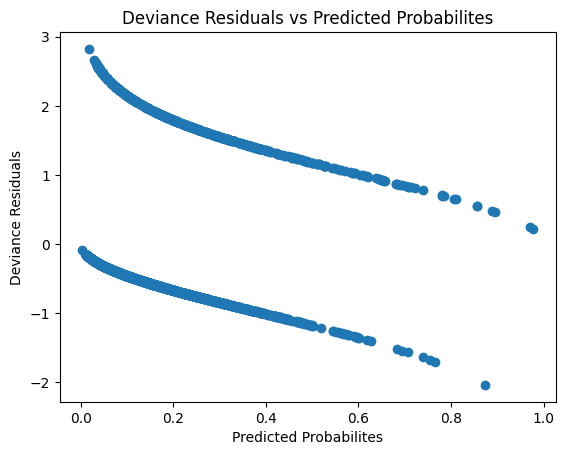

In [95]:
# Deviance residuals
plt.scatter(lr_full_fit.predict(), lr_full_fit.resid_dev)
plt.title('Deviance Residuals vs Predicted Probabilites')
plt.xlabel('Predicted Probabilites')
plt.ylabel('Deviance Residuals')

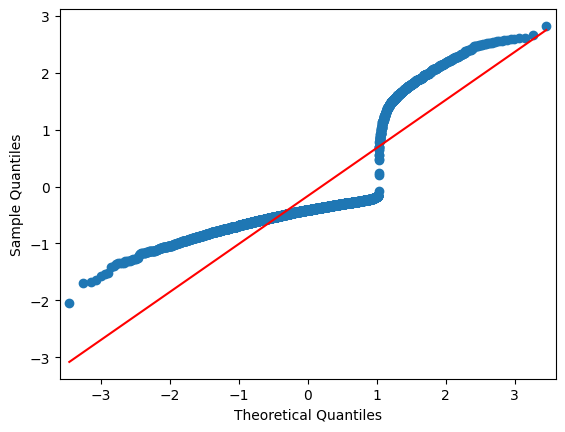

In [96]:
sm.qqplot(lr_full_fit.resid_dev, line='s');

None of these popular residuals are close to being normal. The problem is the fact that the binary data does not meet the so-called *small dispersion asymptotics* which is required for deviance/Pearson residuals to be approximately normal (if we interpret binary data as counts, we would essentially need that every observation has at least observed 3 'successes' for small dispersion asymptotics to hold) [[5](#5)].

This observation, however, provides us with a method to get residuals that are approximately normal. If we aggregate the data by the values of their linear predictor $X\beta$, we obtain groups with a sufficient number of successes in each of them for the asymptotics to hold. 

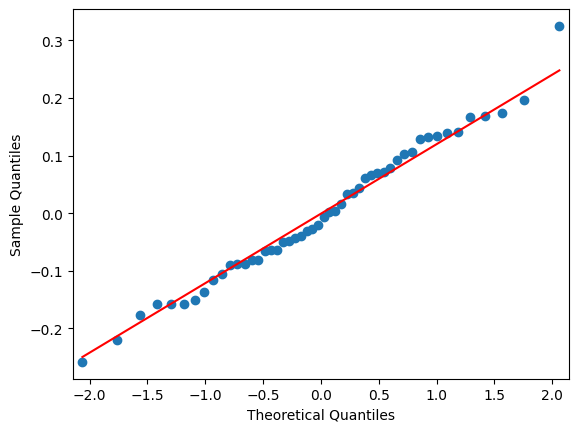

In [108]:
pearson['Lin_pred'] = lr_full_fit.predict(which = 'linear')
# group Pearson residuals by quantiles of linear predictor and calculate mean Pearson residual for each group
sm.qqplot(pearson.groupby(pd.qcut(pearson['Lin_pred'], 50, labels=False)).mean()['Pearson'], line='s'); 

 An alternative approach that we explored in R is to use so-called *quantile residuals* (https://cran.r-project.org/web/packages/DHARMa/vignettes/DHARMa.html#lm-and-glm). These are based on a simulation approach similar to a parametric bootstrap; see The Second Circle: Logistic Regression, Part One for more details.

### Measures of Predictive Performance <a class="anchor" id="performance"></a>

Let us evaluate our model's performance on new data. It is expected that this model will perform worse at predicting the probability of **TCHD** for new data. The following heuristic van Houwelingen and Le Cessie *shrinkage* estimate [[6](#6)] can often estimate the decrease in performance quite well.

In [110]:
# trivial model
lr_triv = smf.logit(formula='TCHD ~ 1',data=framingham_complete)
lr_triv_fit = lr_triv.fit(disp=0) 
# deviance
dev = 2*(lr_full_fit.llf - lr_triv_fit.llf)
# shrinkage
(dev-len(lr_full_fit.params))/dev

0.8734446169776853

The shrinkage factor is 0.87. Thus, we expect the model to perform approximately 13% worse on new data. The model overfits a bit too much (the rule of thumb is 10% shrinkage [[1](#1)]). To reduce overfitting somewhat, we can use the observation that interactions in our model appeared largely insignificant.

In [111]:
lr_final = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3)  + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3)',\
                     data=framingham_complete)
lr_final_fit = lr_final.fit(disp=0)  

dev = 2*(lr_final_fit.llf - lr_triv_fit.llf)
(dev-len(lr_final_fit.params))/dev

0.9174757222967561

This value of estimated shrinkage is much more acceptable. Consequently, we will consider the model without interactions as our final model for predicting the probabilities of **TCHD**.

#### Prediction Accuracy (percentage of correct predictions) <a class="anchor" id="accuracy"></a>

Let us start the evaluation of the predictive performance of the model. The most natural performance metric is overall prediction accuracy. To do so, we first select a probability threshold and then predict that a particular subject will develop **CHD** in ten years if the estimated probability exceeds the threshold.  These predictions are often reported in a so-called *confusion table*, which splits the results into four categories: true positive, false positive, true negative, and false negative. The overall prediction accuracy is then the percentage of true positives and true negatives.


In [117]:
from sklearn.metrics import (confusion_matrix, accuracy_score,\
                             roc_curve, roc_auc_score, log_loss, brier_score_loss)

# predictions
y_pred_prob = lr_final_fit.predict()
y_obs = framingham_complete['TCHD'].to_numpy()

# confusion table for 0.5 threshold
y_pred = (y_pred_prob > 0.5).astype(int)
confusion_matrix(y_obs,y_pred)

array([[3074,   25],
       [ 503,   54]])

In [114]:
# prediction accuracy
accuracy_score(y_obs,y_pred)

0.8555798687089715

The overall accuracy is about 85%; however, this value depends on the threshold. Let's compare the accuracy of predictions for various thresholds.

Text(0, 0.5, 'Accuracy')

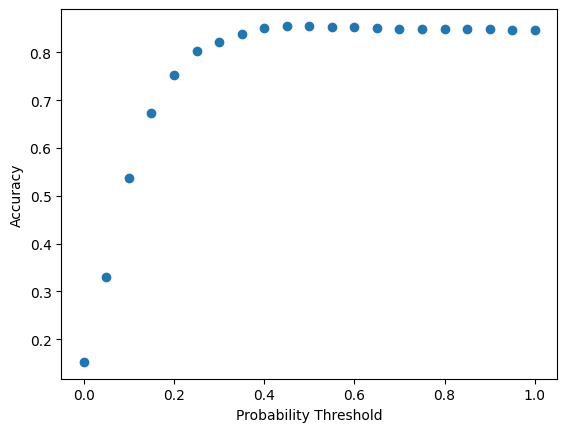

In [123]:
# accuracy
accuracy_score(y_obs,y_pred)

accuracy_scores = np.zeros(21)
accuracy_thresholds = np.zeros(21)

for k in range(21):
    accuracy_thresholds[k] = k/20
    accuracy_scores[k] = accuracy_score(y_obs,(y_pred_prob > accuracy_thresholds[k]).astype(int))
plt.scatter(accuracy_thresholds,accuracy_scores);
plt.xlabel('Probability Threshold')
plt.ylabel('Accuracy')

We see that the accuracy peaks at about the aforementioned 85%. 

There are some serious issues with using the overall accuracy as the performance index. Accuracy is not a proper so-called *scoring rule* (its value is not optimal for the true probability distribution of the outcome). Thus, the model that maximizes accuracy might not correctly model the underlying probability distribution of the outcomes. Accuracy ignores the uncertainty of predictions (it does not care whether the predicted probability of the outcome was 1%, 51%, or 99%; it only cares whether the predicted outcome at a given threshold is correct). 

It is also misleading for an imbalanced prevalence. Think of the dataset with 99% negative results and 1% positive results. In such a dataset, predicting only negative values reaches 99% accuracy. However, the overall accuracy can yield weird recommendations, even for balanced data (see https://www.fharrell.com/post/class-damage/, where a model that ignored an important predictor had better accuracy). 

The last issue we mention here is its dependence on the threshold. As we will see later, selecting a threshold is tied to decision-making (and to considering the costs of those decisions).
<br/>

#### Specificity & Sensitivity, ROC curve <a class="anchor" id="roc"></a>

Since the prevalence heavily influences the accuracy, there are two other popular metrics tied to the outcomes: specificity (true negative rate) and sensitivity (true positive rate). 

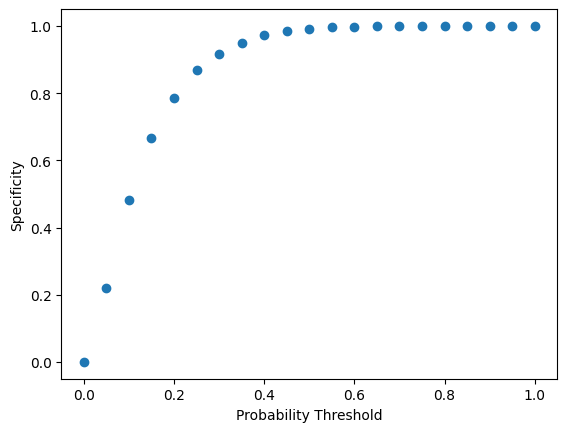

In [125]:
specificity = np.zeros(21)
sensitivity = np.zeros(21)

for k in range(21):
    conf_table = confusion_matrix(y_obs,(y_pred_prob > k/20).astype(int))
    specificity[k] = conf_table[0,0]/(conf_table[0,0] + conf_table[0,1])
    sensitivity[k] = conf_table[1,1]/(conf_table[1,0] + conf_table[1,1])
    
plt.scatter(accuracy_thresholds,specificity)
plt.xlabel('Probability Threshold')
plt.ylabel('Specificity');

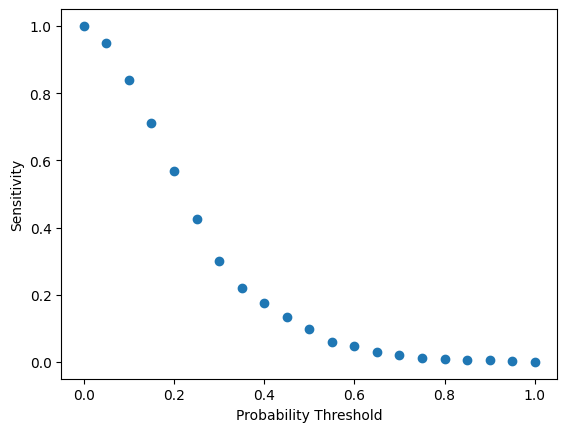

In [127]:
plt.scatter(accuracy_thresholds,sensitivity)
plt.xlabel('Probability Threshold')
plt.ylabel('Sensitivity');

 We see that our model is not very sensitive; we need to choose a relatively low threshold to detect the majority of positive cases (those that actually developed **CHD**), which results in an overall high false positive rate (low specificity). 

In [128]:
# confusion table for 0.1 threshold
y_pred = (y_pred_prob > 0.1).astype(int)
confusion_matrix(y_obs,y_pred)

array([[1495, 1604],
       [  90,  467]])

<br/> Still, we predict about half of the negative cases (those that did not develop *CHD* in ten years) correctly, which could make the model still valuable enough for making decisions (see decision curve analysis later in the text). This analysis provides an example of a typical trade-off between sensitivity and specificity, often depicted for a particular model of binary response using the ROC (Receiver Operating Characteristic) curve.

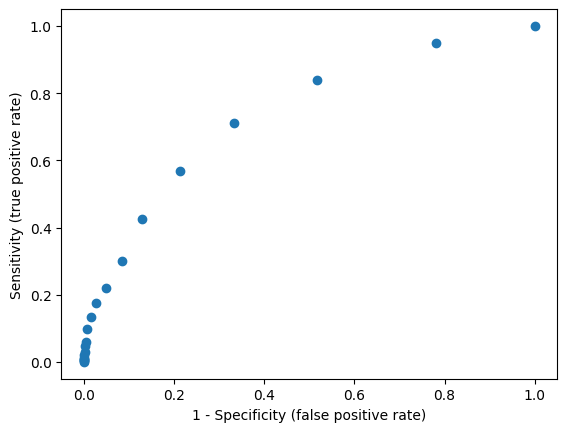

In [134]:
plt.scatter(1-specificity,sensitivity);
plt.xlabel('1 - Specificity (false positive rate)')
plt.ylabel('Sensitivity (true positive rate)');

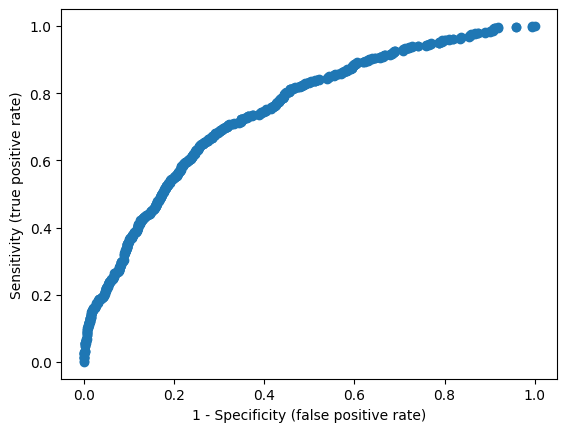

In [133]:
# or  using roc_curve function
fpr, tpr, thresholds = roc_curve(y_obs,y_pred_prob)
plt.scatter(fpr,tpr)
plt.xlabel('1 - Specificity (false positive rate)')
plt.ylabel('Sensitivity (true positive rate)');

The area under the ROC curve () is another popular performance metric for binary classifiers.

In [135]:
roc_auc_score(y_obs,y_pred_prob)

0.747502379582688

A ROC curve area of 0.5 corresponds to random predictions, and a value of 1 indicates perfect predictions (i.e., the model perfectly separates positive and negative results). Generally, a value greater than 0.7 is considered an acceptable predictive power. 

The area under ROC for binary classification equals the *concordance index*. The concordance index is equal to the concordance probability: the proportion of *comparable pairs* in the data (pairs that have different outcomes) that are concordant (individuals with the higher predicted probability experienced the event). 

*c*-index is another improper scoring rule, and thus, *c* can give some weird results [[7](#7)]. It is also a somewhat insensitive metric (adding or removing significant predictors may not change the value of *c*), and thus, it is overall not sufficient for comparing models.

#### Strictly Proper Scoring Rules (logarithmic score and Brier score) <a class="anchor" id="scoring"></a>

The first strictly proper scoring rule we were actually using throughout this project is the logarithimic scoring rule $\sum y_i\mathrm{log} p_i + (1-y_i)\mathrm{log} (1-p_i)$.

In [136]:
(y_obs*np.log(y_pred_prob) + (1-y_obs)*np.log(1-y_pred_prob)).sum()

-1360.3218381906488

We observe that this is nothing but the log-likelihood $\mathrm{log}\,L$ of the logistic model (i.e., this is the scoring rule that the logistic regression coefficients maximize).

In [138]:
lr_final_fit.llf

-1360.3218381906488

We can also compute logarithimic scoring rule (as $-\frac{1}{n}\sum y_i\mathrm{log} p_i + (1-y_i)\,\mathrm{log}\, (1-p_i)$) using the function *log_loss*.

In [139]:
log_loss(y_obs, y_pred_prob)

0.3720792774044444

In [140]:
-(y_obs*np.log(y_pred_prob) + (1-y_obs)*np.log(1-y_pred_prob)).mean()

0.3720792774044444

We used the logarithmic scoring rule to compare nested models throughout this presentation via a likelihood ratio test. Alternatively, we could use Akaike information criterion, which is $\mathrm{AIC} = 2k - 2 \mathrm{log} L$. For example, using AIC to compare our full model with the model without interactions, we would get the difference

In [141]:
lr_full_fit.aic  - lr_final_fit.aic # AIC full model - AIC model without interactions

21.093342730696804

which is significantly greater than 10, indicating that our full model has essentially no support according to the rules-of-thumbs from [[8](#8)]. The logarithmic scoring rule and AIC can be used only to compare models on a particular dataset. Their total value has little meaning. 

Another strictly proper scoring rule commonly used is the Brier score. The Brier score is a mean square error between the observed outcomes (0 and 1) and the estimated probabilities.

In [142]:
((y_obs-y_pred_prob)**2).mean()

0.11335099671704732

In [147]:
brier_score_loss(y_obs,y_pred_prob)

0.11335099671704732

There are two interesting values of estimated probabilities for which we can compute the Brier score: 0.5 and the mean of the observed outcome.

In [146]:
((y_obs-0.5)**2).mean()

0.25

In [145]:
((y_obs-y_obs.mean())**2).mean()

0.12914107501113242

The Brier score for "coin flip" predictions is always 0.25. The second Brier score corresponds to predicting the outcome based on overall prevalence. We see that our model is better than that

The optimal value of the Brier score depends on the actual distribution. Consequently, the absolute value of the Brier score may be a bit misleading, depending on the distribution of the outcome [[9](#9)]. However, the Brier score is easier to interpret than the logarithmic scoring rule overall, and its values are somewhat comparable across models and data sets when the underlying distribution is the same. 

#### Calibration <a class="anchor" id="calibration"></a>

The model's predicted probabilities should correspond to the actual probabilities. Otherwise, the model might be too confident in its predictions. Logistic regression models are typically well-calibrated because they optimize the logarithmic scoring rule.

The simplest evaluation of calibration is to split the data by predicted probability (e.g., deciles) and compare the estimated mean probabilities with the observed proportions. 

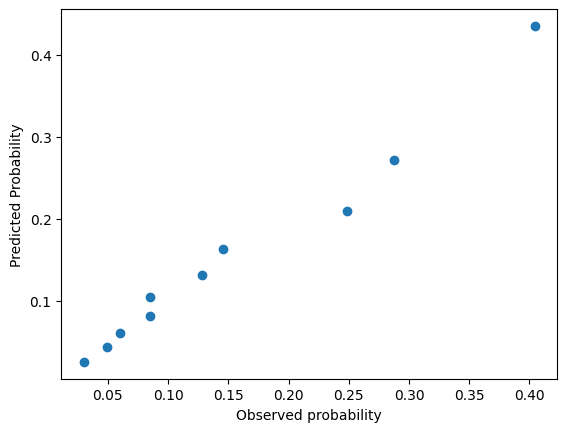

In [167]:
from sklearn.calibration import calibration_curve  
prob_true, prob_pred = calibration_curve(y_obs,y_pred_prob, n_bins=10, strategy = 'quantile')
plt.scatter(prob_true,prob_pred);
plt.xlabel('Observed probability')
plt.ylabel('Predicted Probability');

In [156]:
sm.OLS(endog = prob_pred, exog = pd.DataFrame(prob_true).assign(const=1)).fit(disp=0).params.iloc[0] # OLS fit using the calibration data

1.012702800020864

We see that the points are near the diagonal. Since logistic regression is usually well-calibrated on the training data, we can evaluate calibration by fitting a logistic regression model to the predicted probabilities.

In [161]:
logitp = np.log(y_pred_prob/(1-y_pred_prob)) # logit p = log p/(1-p)
calib_model_fit = sm.Logit(endog= framingham_complete['TCHD'],exog = pd.DataFrame(logitp).assign(const=1)).fit(disp=0) # fit logit
print(calib_model_fit.summary())

                           Logit Regression Results                           
Dep. Variable:                   TCHD   No. Observations:                 3656
Model:                          Logit   Df Residuals:                     3654
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.1281
Time:                        12:25:35   Log-Likelihood:                -1360.3
converged:                       True   LL-Null:                       -1560.3
Covariance Type:            nonrobust   LLR p-value:                 5.842e-89
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.0000      0.056     17.962      0.000       0.891       1.109
const      -5.787e-16      0.095  -6.06e-15      1.000      -0.187       0.187


Since we used a logistic model in the first place, this fit naturally has a slope of one. On the new data, this slope would, however, be different from one in general, indicating that the model may no longer be as well calibrated on the new data. 

#### Decision Curve Analysis <a class="anchor" id="dca"></a>

The previously mentioned performance and calibration indices did not assess whether the model is actually good at making decisions. Decision curve analysis (DCA) attempts to remedy that [[10](#10)].

We consider a simple decision problem. Let the probability of the condition (in our case **TCHD**) be $p$. We have four outcomes: true positive, false positive (followed by treatment), false negative, and true negative (followed by no treatment). Let the value of the outcomes be $a, b, c$, and $d$, respectively. Threshold probability $p_t$, when the expected benefit of the treatment is equal to the expected benefit of avoiding the treatment, meets
$p_ta + (1-p_t)b = p_tc + (1-p_t)d$, i.e., $\frac{1-p_t}{p_t} = \frac{a-c}{d-b}$: $d-b$ is a consequence of being treated unnecessarily (false positive result),  $a − c$ is the consequence of avoiding treatment (false negative result). Thus, we should select the threshold probability $p_t$ based on our choice of the ratio $\frac{a-c}{d-b}$ (the ratio of the consequences of a false positive outcome and a false negative outcome).

Let $\hat{p}$ be the estimated probability of the condition using our model. Let's fix the consequence of a false negative result as $a-c = 1$, then the consequence of a false positive result is $d-b = -\frac{\hat{p}_t}{1-\hat{p}_t}$. The net benefit for the threshold probability $\hat{p}_t$ is given as  $$\mathrm{net\;benefit} = \frac{\mathrm{true\; positive\; count} (\hat{p}_t)}{n}  - \frac{\mathrm{false\; positive\; count }(\hat{p}_t)}{n}\frac{\hat{p}_t}{1-\hat{p}_t}$$ where true positive and false positive counts are evaluated based on the threshold $\hat{p}_t$ [[10](#10)].

The DCA is visualized by the following plot comparing the treat-all and treat-none policies with the policy based on predicted probabilities obtained from our model.

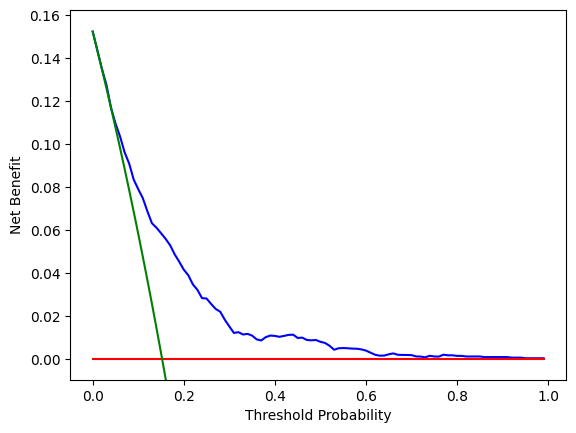

In [168]:
dca_curve  = np.zeros(100)
tall_curve =  np.zeros(100)
tnone_curve = np.zeros(100)

negative_c = (framingham_complete['TCHD'] == 0).sum()
positive_c = (framingham_complete['TCHD'] == 1).sum()
dca_thresholds = np.zeros(100)

for k in range(100):
    dca_thresholds[k] = k/100
    conf_table = confusion_matrix(y_obs,(y_pred_prob > dca_thresholds[k]).astype(int))
    dca_curve[k] = 1/len(framingham_complete)*\
        (conf_table[1,1] - conf_table[0,1]*dca_thresholds[k]/(1-dca_thresholds[k]))
    tall_curve[k] = 1/len(framingham_complete)*\
        (positive_c - negative_c*dca_thresholds[k]/(1-dca_thresholds[k]))
    tnone_curve[k] = 0
    
plt.plot(dca_thresholds,dca_curve,color = 'blue')
plt.plot(dca_thresholds,tnone_curve, color = 'red')
plt.plot(dca_thresholds,tall_curve, color = 'green')
plt.ylim(dca_curve[99]-0.01, dca_curve[0]+0.01);
plt.xlabel('Threshold Probability')
plt.ylabel('Net Benefit');

We see that our model is uniformly better at making decisions in terms of net benefit than the treat-all and treat-none policies. Thus, our model could be helpful in decision-making in practice.

## Model Validation <a class="anchor" id="validation"></a>

We estimated the performance metrics on the complete data. Next, we will estimate their generalizability to new data using cross-validation.

In [264]:
np.random.seed(123)

rep = 100
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv =  pd.DataFrame(index=range(rep*folds),columns = ['c-index (AUC)','Brier score','log score','calibration'])
dca_curve_cv  = pd.DataFrame(index=range(rep*folds),columns = range(100))

k = 0
for i in range(rep):
    idx_cv = np.random.choice([*range(len(framingham_complete))],len(framingham_complete), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        lr_cv_new = smf.logit(formula='TCHD ~ Sex + bs(Age, lower_bound=30, upper_bound = 75, df=3) + C(Edu, Poly) + \
                             bs(Cig, lower_bound= 0, upper_bound = 80, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, lower_bound= 100, upper_bound = 600, df=3) + \
                             bs(SysP, lower_bound= 80, upper_bound = 300, df=3) + bs(DiaP, lower_bound= 45, upper_bound = 150, df=3) + \
                             bs(BMI, lower_bound= 15, upper_bound = 60, df=3) + bs(Hrate, lower_bound= 40, upper_bound = 150, df=3) + \
                             bs(Gluc, df=3, lower_bound= 40, upper_bound = 400)',
                             data=framingham_complete.iloc[train_set])
        
        y_pred_prob_new = lr_cv_new.fit(disp=0).predict(framingham_complete.iloc[test_set]) 
        y_obs_new = framingham_complete.iloc[test_set]['TCHD']
        logitp_new = np.log(y_pred_prob_new/(1-y_pred_prob_new))
        
        metrics_cv.iloc[k,0] = roc_auc_score(y_obs_new,y_pred_prob_new)
        metrics_cv.iloc[k,1] = brier_score_loss(y_obs_new,y_pred_prob_new)
        metrics_cv.iloc[k,2] = log_loss(y_obs_new,y_pred_prob_new)
        metrics_cv.iloc[k,3] = sm.Logit(endog= y_obs_new,exog = pd.DataFrame(logitp_new).assign(const=1)).fit(disp=0).params.iloc[0]
        
        for n in range(100):
            conf_table_new = confusion_matrix(y_obs_new,(y_pred_prob_new > dca_thresholds[n]).astype(int))
            dca_curve_cv.iloc[k,n] = 1/len(test_set)*\
                (conf_table_new[1,1] - conf_table_new[0,1]*dca_thresholds[n]/(1-dca_thresholds[n]))
            
        k = k + 1

In [267]:
metrics_cv.mean()

c-index (AUC)    0.730285
Brier score      0.116806
log score        0.383871
calibration      0.889377
dtype: object

We observe that the predicted c-index on new data is slightly lower. Analogously, the Brier score and the logarithmic score estimate are a bit higher. The model is also no longer perfectly calibrated. Nevertheless, overall, the performance did not degrade much. 

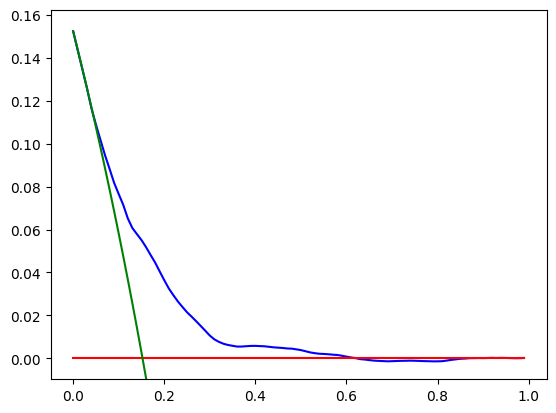

In [268]:
plt.plot(dca_thresholds,dca_curve_cv.mean(),color = 'blue')
plt.plot(dca_thresholds,tnone_curve, color = 'red')
plt.plot(dca_thresholds,tall_curve, color = 'green')
plt.ylim(dca_curve[99]-0.01, dca_curve[0]+0.01);

We see that the expected net benefit of our model remains uniformly better than the treat-all and treat-none policies up to about 60% threshold.

## Mean and Most-Frequent Imputation <a class="anchor" id="mean-imputation"></a>

The complete case analysis is a straightforward but wasteful approach to handling missing data. Mean imputation is another quick fix for missing data, replacing missing values with their mean (or the most frequent category for categorical data). We should, however, keep in mind that mean imputation can distort relationships among variables (biasing regression estimates) [[2](#2)]. 

Let us first check which variables are missing in the data.

In [193]:
framingham.isna().sum(axis = 0)

Sex         0
Age         0
Edu       105
Smoker      0
Cig        29
Meds       53
Stroke      0
Hyp         0
Diab        0
Chol       50
SysP        0
DiaP        0
BMI        19
Hrate       1
Gluc      388
TCHD        0
dtype: int64

First, we impute the categorical variables using the most-frequent imputation.

In [196]:
from sklearn.impute import SimpleImputer

mfreq_imp_fit = SimpleImputer(missing_values =np.nan, strategy="most_frequent").fit(framingham[['Edu','Meds']])

We impute **Hrate**, **BMI**, **Gluc**, and **Chol** using their population mean values.

In [205]:
mean_imp_fit = SimpleImputer(missing_values = np.nan, strategy='mean').fit(framingham[['Chol','BMI','Hrate','Gluc']])

 As far as **Cigs** is concerned, we can do a bit better. A nonsmoker would smoke zero cigarettes per day. However, there is no nonsmoker in the data with **Cigs** missing.

In [200]:
((framingham['Cig'].isna()) & (framingham['Smoker'] == 0)).any()

False

Hence, we impute missing **Cigs** values with the conditional mean for smokers. 

In [204]:
mean_imp_fit_cig = SimpleImputer(missing_values = np.nan, strategy='mean').fit(pd.DataFrame(framingham.loc[framingham['Smoker'] == 1]['Cig']))

Let us fit the model for the imputed dataset.

In [206]:
framingham_mean_imp = framingham.copy()
framingham_mean_imp[['Chol','BMI','Hrate','Gluc']] = \
    mean_imp_fit.transform(framingham_mean_imp[['Chol','BMI','Hrate','Gluc']])
framingham_mean_imp[['Cig']] = mean_imp_fit_cig.transform(framingham_mean_imp[['Cig']])
framingham_mean_imp[['Edu','Meds']] = mfreq_imp_fit.transform(framingham_mean_imp[['Edu','Meds']])

lr_full_mean_imp = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3)  + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_mean_imp)                            

lr_full_mean_imp_fit = lr_full_mean_imp.fit(disp=0)
print(lr_full_mean_imp_fit.summary())


                           Logit Regression Results                           
Dep. Variable:                   TCHD   No. Observations:                 4238
Model:                          Logit   Df Residuals:                     4185
Method:                           MLE   Df Model:                           52
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.1268
Time:                        19:57:53   Log-Likelihood:                -1576.8
converged:                       True   LL-Null:                       -1805.8
Covariance Type:            nonrobust   LLR p-value:                 2.556e-66
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.8263      1.400     -1.305      0.192      -4.569       0.917
C(Edu, Poly).Linear        0.0682      0.109      0.624      0.533      -0.146       0.283
C(Ed

We could repeat the inference for the imputed data using the same methods as for the complete-case analysis. However, such an inference would 
not account for the fact that these data were imputed. To obtain inferences that account for imputation, we can use a pairs bootstrap. The confidence intervals can be computed using the percentile-based method, as we did in Part One for our CRE model. The significance of predictors can be tested using the *bootstrap Wald test*.

First, we compute the Wald test statistic for the original sample: $W = \hat{\theta}^T\, \mathrm{Cov}(\hat{\theta})^{-1} \hat{\theta}$. Then, we compute for each bootstrap sample the Wald test statistic $W' = (\theta' - \hat{\theta})^T\, \mathrm{Cov}(\theta')^{-1} (\theta' - \hat{\theta})$, where $\theta'$ is the estimate for the bootstrap sample. The p-value for the test is then $\frac{\mathrm{count}\; W' > W}{\mathrm{count}\; W'}$. The idea behind the test is that under the alternative, the Wald test statistic $W$ between $\hat{\theta}$ and the null $\theta_0 = 0$ should be much larger than the Wald test statistic $W'$ between $\hat{\theta}$ and $\theta'$ [[11](#11)].

To demonstrate the bootstrap Wald test, we will perform it to test the significance of interactions, **stroke**, and **age**.

In [214]:
# wald statistic for interactions
params = lr_full_mean_imp_fit.params.iloc[range(33,53)]
cov_params = lr_full_mean_imp_fit.cov_params().iloc[range(33,53)].iloc[:,range(33,53)]
wald_stat = np.transpose(params) @ np.linalg.inv(cov_params) @ params

# wald statistic for stroke
params2 = lr_full_mean_imp_fit.params.iloc[[12,34,44]]
cov_params2 = lr_full_mean_imp_fit.cov_params().iloc[[12,34,44]].iloc[:,[12,34,44]]
wald_stat2 = np.transpose(params2) @ np.linalg.inv(cov_params2) @ params2

# wald statistic for age
params3 = lr_full_mean_imp_fit.params.iloc[[*range(5,8),*range(33,43)]]
cov_params3 = lr_full_mean_imp_fit.cov_params().iloc[[*range(5,8),*range(33,43)]].iloc[:,[*range(5,8),*range(33,43)]]
wald_stat3 = np.transpose(params3) @ np.linalg.inv(cov_params3) @ params3

In [ ]:
np.random.seed(123)
nb = 1000
wald_test = pd.DataFrame(index=range(nb),columns = ['Wald'])
wald_test2 = pd.DataFrame(index=range(nb),columns = ['Wald'])
wald_test3 = pd.DataFrame(index=range(nb),columns = ['Wald'])

import warnings
warnings.filterwarnings('ignore')

for i in range(nb):
    rand_ind = np.random.choice(range(len(framingham)), size=len(framingham), replace=True)
    framingham_new = framingham.iloc[rand_ind]
    
    mean_imp_fit_cig_new = SimpleImputer(missing_values = np.nan, strategy='mean').fit(pd.DataFrame(framingham_new.loc[framingham_new['Smoker'] == 1]['Cig']))
    mean_imp_fit_new = SimpleImputer(missing_values = np.nan, strategy='mean').fit(framingham_new[['Chol','BMI','Hrate','Gluc']])
    mfreq_imp_fit_new = SimpleImputer(missing_values =np.nan, strategy="most_frequent").fit(framingham_new[['Edu','Meds']])
    
    framingham_mean_imp_new = framingham_new.copy()
    framingham_mean_imp_new[['Chol','BMI','Hrate','Gluc']] = \
        mean_imp_fit.transform(framingham_mean_imp_new[['Chol','BMI','Hrate','Gluc']])
    framingham_mean_imp_new[['Cig']] = mean_imp_fit_cig.transform(framingham_mean_imp_new[['Cig']])
    framingham_mean_imp_new[['Edu','Meds']] = mfreq_imp_fit.transform(framingham_mean_imp_new[['Edu','Meds']])
    
    lr_full_mean_imp_new = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                         bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                         Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                         Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_mean_imp_new)
     
    try:
        lr_full_mean_imp_new_fit = lr_full_mean_imp_new.fit(disp=0)                     
         
        params_new = (lr_full_mean_imp_new_fit.params.iloc[range(33,53)] - params)
        cov_params_new  = lr_full_mean_imp_new_fit.cov_params().iloc[range(33,53)].iloc[:,range(33,53)]
        wald_test.iloc[i] = np.transpose(params_new) @ np.linalg.inv(cov_params_new) @ params_new
        
        params_new2 = (lr_full_mean_imp_new_fit.params.iloc[[12,34,44]] - params2)
        cov_params_new2  = lr_full_mean_imp_new_fit.cov_params().iloc[[12,34,44]].iloc[:,[12,34,44]]
        wald_test2.iloc[i] = np.transpose(params_new2) @ np.linalg.inv(cov_params_new2) @ params_new2
        
        params_new3 = (lr_full_mean_imp_new_fit.params.iloc[[*range(5,8),*range(33,43)]] - params3)
        cov_params_new3  = lr_full_mean_imp_new_fit.cov_params().iloc[[*range(5,8),*range(33,43)]].iloc[:,[*range(5,8),*range(33,43)]]
        wald_test3.iloc[i] = np.transpose(params_new3) @ np.linalg.inv(cov_params_new3) @ params_new3
        
    except:
        wald_test.iloc[i] = np.nan
        wald_test2.iloc[i] = np.nan
        wald_test3.iloc[i] = np.nan
    
warnings.filterwarnings('default')

In [220]:
(wald_stat <  wald_test).mean() # p-value for interactions

Wald    0.262
dtype: float64

In [221]:
(wald_stat2 < wald_test2).mean() # p-value for stroke

Wald    0.094
dtype: float64

In [222]:
(wald_stat3 < wald_test3).mean() # p-value for age

Wald    0.001
dtype: float64

We observe that interactions are not significant, and **age** is highly significant as was the case in the complete case analysis. Interestingly enough, the **stroke** that was largely nonsignificant in the complete case analysis (due to the lack of data) is now borderline significant. This demonstrates that imputation can be pretty helpful. However, we still need to keep in mind that the mean/most-frequent imputation provides biased estimates even under the MCAR (missing completely at random) condition, and the bootstrap does not account for this. Consequently, we should prefer other imputation methods if precise inference is our primary concern. 

Let us investigate the predictive performance of our model with the mean/most-frequent imputation.

In [261]:
np.random.seed(123)

rep = 100
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_mean_imp =  pd.DataFrame(index=range(rep*folds),columns = ['c-index (AUC)','Brier score','log score','calibration'])
dca_curve_cv_mean_imp  = pd.DataFrame(index=range(rep*folds),columns = range(100))

k = 0
for i in range(rep):
    idx_cv = np.random.choice([*range(len(framingham))],len(framingham), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        framingham_train = framingham.iloc[train_set]
        framingham_test = framingham.iloc[test_set]
        
        mean_imp_fit_cig_new = SimpleImputer(missing_values = np.nan, strategy='mean').fit(pd.DataFrame(framingham_train.loc[framingham_train['Smoker'] == 1]['Cig']))
        mean_imp_fit_new = SimpleImputer(missing_values = np.nan, strategy='mean').fit(framingham_train[['Chol','BMI','Hrate','Gluc']])
        mfreq_imp_fit_new = SimpleImputer(missing_values =np.nan, strategy="most_frequent").fit(framingham_train[['Edu','Meds']])

        framingham_train_mean_imp = framingham_train.copy()
        framingham_train_mean_imp[['Cig']] = mean_imp_fit_cig_new.transform(framingham_train_mean_imp[['Cig']])
        framingham_train_mean_imp[['Chol','BMI','Hrate','Gluc']] = \
            mean_imp_fit_new.transform(framingham_train_mean_imp[['Chol','BMI','Hrate','Gluc']])
        framingham_train_mean_imp[['Edu','Meds']] = mfreq_imp_fit_new.transform(framingham_train_mean_imp[['Edu','Meds']])
            

        lr_cv_new = smf.logit(formula='TCHD ~ Sex + bs(Age, lower_bound=30, upper_bound = 75, df=3) + C(Edu, Poly) + \
                             bs(Cig, lower_bound= 0, upper_bound = 80, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, lower_bound= 100, upper_bound = 700, df=3) + \
                             bs(SysP, lower_bound= 80, upper_bound = 300, df=3) + bs(DiaP, lower_bound= 45, upper_bound = 150, df=3) + \
                             bs(BMI, lower_bound= 15, upper_bound = 60, df=3) + bs(Hrate, lower_bound= 40, upper_bound = 150, df=3) + \
                             bs(Gluc, df=3, lower_bound= 40, upper_bound = 400)',
                             data=framingham_train_mean_imp)
            
        framingham_test_mean_imp = framingham_test.copy()
        framingham_test_mean_imp[['Cig']] = mean_imp_fit_cig_new.transform(framingham_test_mean_imp[['Cig']])
        framingham_test_mean_imp[['Chol','BMI','Hrate','Gluc']] = \
            mean_imp_fit_new.transform(framingham_test_mean_imp[['Chol','BMI','Hrate','Gluc']])
        framingham_test_mean_imp[['Edu','Meds']] = mfreq_imp_fit_new.transform(framingham_test_mean_imp[['Edu','Meds']])
            
            
        y_pred_prob_new = lr_cv_new.fit(disp=0).predict(framingham_test_mean_imp) 
        y_obs_new = framingham_test_mean_imp['TCHD']
        logitp_new = np.log(y_pred_prob_new/(1-y_pred_prob_new))
        
        metrics_cv_mean_imp.iloc[k,0] = roc_auc_score(y_obs_new,y_pred_prob_new)
        metrics_cv_mean_imp.iloc[k,1] = brier_score_loss(y_obs_new,y_pred_prob_new)
        metrics_cv_mean_imp.iloc[k,2] = log_loss(y_obs_new,y_pred_prob_new)
        metrics_cv_mean_imp.iloc[k,3] = sm.Logit(endog= y_obs_new,exog = pd.DataFrame(logitp_new).assign(const=1)).fit(disp=0).params.iloc[0]
        
        for n in range(100):
            conf_table_new = confusion_matrix(y_obs_new,(y_pred_prob_new > dca_thresholds[n]).astype(int))
            dca_curve_cv_mean_imp.iloc[k,n] = 1/len(test_set)*\
                (conf_table_new[1,1] - conf_table_new[0,1]*dca_thresholds[n]/(1-dca_thresholds[n]))
            
        k = k + 1

In [262]:
metrics_cv_mean_imp.mean()

c-index (AUC)     0.72299
Brier score      0.117186
log score        0.387034
calibration      0.874847
dtype: object

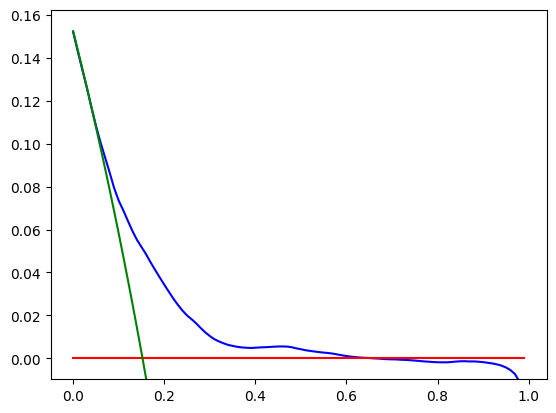

In [263]:
plt.plot(dca_thresholds,dca_curve_cv_mean_imp.mean(),color = 'blue')
plt.plot(dca_thresholds,tnone_curve, color = 'red')
plt.plot(dca_thresholds,tall_curve, color = 'green')
plt.ylim(dca_curve[99]-0.01, dca_curve[0]+0.01);

We observe that the results are fairly similar to the complete case analysis.

## k-NN Imputation <a class="anchor" id="knn"></a>

Imputation based on the k-NN algorithm is another popular and well-performing imputation technique [[12](#12),[13](#13)]. Unlike the mean/most-frequent imputation, it preserves the relations between variables. Apart from computational complexity for very large datasets, its main disadvantage is that we have to retain the entire original dataset to impute new values.

In [304]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

variables = ['Sex','Age','Edu','Cig','Meds','Stroke','Hyp','Diab','Chol','SysP','DiaP','BMI','Hrate','Gluc','Smoker']
predictors = framingham[variables]

scaler = StandardScaler().fit(predictors) 
predictors_scaled = scaler.transform(predictors)
knn_imputer = KNNImputer(n_neighbors=10).fit(predictors_scaled)

framingham_knn_imp = framingham.copy()
# rescale the predictors so that the Euclidean distances are in a comparable scale in all dimensions
framingham_knn_imp[variables] = scaler.inverse_transform(knn_imputer.transform(predictors_scaled))
# kNN averages the values of predictors of neighbouring observations -> rounding to obtain values for categorical predictors
framingham_knn_imp['Edu'] = round(framingham_knn_imp['Edu'])
framingham_knn_imp['Meds'] = round(framingham_knn_imp['Meds'])

lr_full_knn_imp = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3)  + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_knn_imp)                            

lr_full_knn_imp_fit = lr_full_knn_imp.fit(disp=0)
print(lr_full_knn_imp_fit.summary())


                           Logit Regression Results                           
Dep. Variable:                   TCHD   No. Observations:                 4238
Model:                          Logit   Df Residuals:                     4185
Method:                           MLE   Df Model:                           52
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:                  0.1271
Time:                        10:55:30   Log-Likelihood:                -1576.2
converged:                       True   LL-Null:                       -1805.8
Covariance Type:            nonrobust   LLR p-value:                 1.492e-66
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.8561      1.401     -1.325      0.185      -4.601       0.889
C(Edu, Poly).Linear        0.0702      0.110      0.639      0.523      -0.145       0.285
C(Ed

Let us compare the performance of our model with the k-NN imputation with the mean/most-frequent imputation.

In [259]:
# cross-validation
np.random.seed(123)

rep = 100
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_knn_imp =  pd.DataFrame(index=range(rep*folds),columns = ['c-index (AUC)','Brier score','log score','calibration'])
dca_curve_cv_knn_imp  = pd.DataFrame(index=range(rep*folds),columns = range(100))

k = 0
for i in range(rep):
    idx_cv = np.random.choice([*range(len(framingham))],len(framingham), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        framingham_train = framingham.iloc[train_set]
        framingham_test = framingham.iloc[test_set]
        
        predictors_new = framingham_train[variables]
        scaler_new = StandardScaler().fit(predictors_new)
        predictors_scaled_new = scaler_new.transform(predictors_new)
        knn_imputer_new = KNNImputer(n_neighbors=10).fit(predictors_scaled_new)
        
        
        framingham_knn_new = framingham_train.copy()
        framingham_knn_new[variables] = scaler_new.inverse_transform(knn_imputer_new.transform(predictors_scaled_new))
        framingham_knn_new['Edu'] = round(framingham_knn_new['Edu'])
        framingham_knn_new['Meds'] = round(framingham_knn_new['Meds'])
        
        
        lr_cv_new = smf.logit(formula='TCHD ~ Sex + bs(Age, lower_bound=30, upper_bound = 75, df=3) + C(Edu, Poly) + \
                             bs(Cig, lower_bound= 0, upper_bound = 80, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, lower_bound= 100, upper_bound = 700, df=3) + \
                             bs(SysP, lower_bound= 80, upper_bound = 300, df=3) + bs(DiaP, lower_bound= 45, upper_bound = 150, df=3) + \
                             bs(BMI, lower_bound= 15, upper_bound = 60, df=3) + bs(Hrate, lower_bound= 40, upper_bound = 150, df=3) + \
                             bs(Gluc, df=3, lower_bound= 30, upper_bound = 400)',
                             data=framingham_knn_new)
        
        predictors_test =  framingham_test[variables]
        predictors_test_scaled = scaler_new.transform(predictors_test)
        framingham_knn_test = framingham_test.copy()
        framingham_knn_test[variables] = scaler_new.inverse_transform(knn_imputer_new.transform(predictors_test_scaled))
        framingham_knn_test['Edu'] = round(framingham_knn_test['Edu'])
        framingham_knn_test['Meds'] = round(framingham_knn_test['Meds'])
        
        
      
        y_pred_prob_new = lr_cv_new.fit(disp=0).predict(framingham_knn_test) 
        y_obs_new = framingham_knn_test['TCHD']
        logitp_new = np.log(y_pred_prob_new/(1-y_pred_prob_new))
        
        metrics_cv_knn_imp.iloc[k,0] = roc_auc_score(y_obs_new,y_pred_prob_new)
        metrics_cv_knn_imp.iloc[k,1] = brier_score_loss(y_obs_new,y_pred_prob_new)
        metrics_cv_knn_imp.iloc[k,2] = log_loss(y_obs_new,y_pred_prob_new)
        metrics_cv_knn_imp.iloc[k,3] = sm.Logit(endog= y_obs_new,exog = pd.DataFrame(logitp_new).assign(const=1)).fit(disp=0).params.iloc[0]
        
        for n in range(100):
            conf_table_new = confusion_matrix(y_obs_new,(y_pred_prob_new > dca_thresholds[n]).astype(int))
            dca_curve_cv_knn_imp.iloc[k,n] = 1/len(test_set)*\
                (conf_table_new[1,1] - conf_table_new[0,1]*dca_thresholds[n]/(1-dca_thresholds[n]))
            
        k = k + 1

In [266]:
metrics_cv_knn_imp.mean()

c-index (AUC)    0.723612
Brier score      0.117111
log score        0.386755
calibration      0.875124
dtype: object

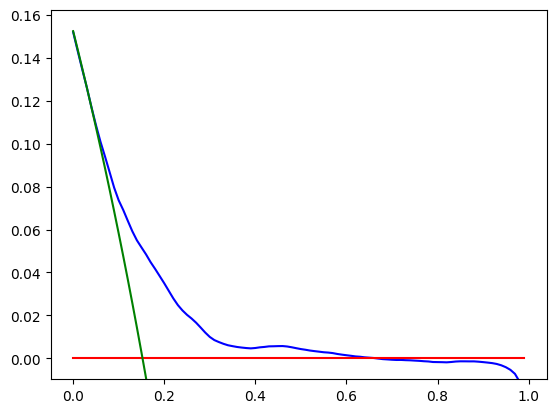

In [265]:
plt.plot(dca_thresholds,dca_curve_cv_knn_imp.mean(),color = 'blue')
plt.plot(dca_thresholds,tnone_curve, color = 'red')
plt.plot(dca_thresholds,tall_curve, color = 'green')
plt.ylim(dca_curve[99]-0.01, dca_curve[0]+0.01);

We observe that the results are almost identical to mean/most-frequent imputation. We obtained only a marginal improvement in terms of the performance metrics.

## MissForrest Imputation <a class="anchor" id="missforrest"></a>

MissForrest is an imputation algorithm based on random forests (Python implementation uses lgbm by default) that model the relations between each predictor and the rest of the predictors [[14](#14)], and it is one of the best-performing imputational algorithms by numerous computational experiments [[15](#15),[16](#16),[17](#17)]. However, in comparison to other techniques we used, MissForrest is much more computationally expensive.

In [271]:
from missforest import MissForest

categorical=['Sex','Edu','Smoker','Meds','Stroke','Hyp','Diab']

warnings.filterwarnings('ignore')

MissForest_imputation = MissForest(categorical=categorical)
MissForest_imputation._verbose = 0

MissForest_imputation.fit(x = framingham[variables])
framingham_MissForest = framingham.copy()

framingham_MissForest[variables] =  MissForest_imputation.transform(x = framingham[variables])[variables]

lr_full_missforrest_imp = smf.logit(formula='TCHD ~ Sex + bs(Age, df=3) + C(Edu, Poly) + bs(Cig, df=3)  + Meds + Stroke + Hyp + Diab + bs(Chol, df=3) + \
                     bs(SysP, df=3) + bs(DiaP, df=3) + bs(BMI, df=3) + bs(Hrate, df=3) + bs(Gluc, df=3) + \
                     Age:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc) + \
                     Sex:(Cig + Stroke + Hyp + Diab + Chol + SysP + DiaP + BMI + Hrate + Gluc)', data=framingham_MissForest)                            

print(lr_full_missforrest_imp.fit(disp=0).summary())
warnings.filterwarnings('default')

                           Logit Regression Results                           
Dep. Variable:                   TCHD   No. Observations:                 4238
Model:                          Logit   Df Residuals:                     4185
Method:                           MLE   Df Model:                           52
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.1277
Time:                        23:43:47   Log-Likelihood:                -1575.2
converged:                       True   LL-Null:                       -1805.8
Covariance Type:            nonrobust   LLR p-value:                 6.464e-67
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.8211      1.401     -1.300      0.194      -4.567       0.924
C(Edu, Poly).Linear        0.0687      0.109      0.628      0.530      -0.146       0.283
C(Ed

In [300]:
# cross-validation
np.random.seed(123)

rep = 100
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_missforest_imp =  pd.DataFrame(index=range(rep*folds),columns = ['c-index (AUC)','Brier score','log score','calibration'])
dca_curve_cv_missforest_imp  = pd.DataFrame(index=range(rep*folds),columns = range(100))



warnings.filterwarnings('ignore')

k = 0
for i in range(rep):
    idx_cv = np.random.choice([*range(len(framingham))],len(framingham), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        framingham_train = framingham.iloc[train_set]
        framingham_test = framingham.iloc[test_set]
        
        missforest_imputer_new = MissForest(categorical=categorical)
        missforest_imputer_new._verbose = 0
        missforest_imputer_new_fit = missforest_imputer_new.fit(x = framingham_train[variables])
                
        framingham_missforest_new = framingham_train.copy()
        framingham_missforest_new[variables] = missforest_imputer_new_fit.transform(framingham_train[variables])[variables]
        
        
        lr_cv_new = smf.logit(formula='TCHD ~ Sex + bs(Age, lower_bound=30, upper_bound = 75, df=3) + C(Edu, Poly) + \
                             bs(Cig, lower_bound= 0, upper_bound = 80, df=3) + Meds + Stroke + Hyp + Diab + bs(Chol, lower_bound= 80, upper_bound = 700, df=3) + \
                             bs(SysP, lower_bound= 80, upper_bound = 300, df=3) + bs(DiaP, lower_bound= 45, upper_bound = 150, df=3) + \
                             bs(BMI, lower_bound= 15, upper_bound = 60, df=3) + bs(Hrate, lower_bound= 40, upper_bound = 150, df=3) + \
                             bs(Gluc, df=3, lower_bound= 20, upper_bound = 400)',
                             data = framingham_missforest_new)
        


        framingham_missforest_test = framingham_test.copy()
        framingham_missforest_test[variables] = missforest_imputer_new_fit.transform(framingham_test[variables])[variables]


        y_pred_prob_new = lr_cv_new.fit(disp=0).predict(framingham_missforest_test) 
        y_obs_new = framingham_missforest_test['TCHD']
        logitp_new = np.log(y_pred_prob_new/(1-y_pred_prob_new))
        
        metrics_cv_missforest_imp.iloc[k,0] = roc_auc_score(y_obs_new,y_pred_prob_new)
        metrics_cv_missforest_imp.iloc[k,1] = brier_score_loss(y_obs_new,y_pred_prob_new)
        metrics_cv_missforest_imp.iloc[k,2] = log_loss(y_obs_new,y_pred_prob_new)
        metrics_cv_missforest_imp.iloc[k,3] = sm.Logit(endog= y_obs_new,exog = pd.DataFrame(logitp_new).assign(const=1)).fit(disp=0).params.iloc[0]
        
        for n in range(100):
            conf_table_new = confusion_matrix(y_obs_new,(y_pred_prob_new > dca_thresholds[n]).astype(int))
            dca_curve_cv_missforest_imp.iloc[k,n] = 1/len(test_set)*\
                (conf_table_new[1,1] - conf_table_new[0,1]*dca_thresholds[n]/(1-dca_thresholds[n]))
            
        k = k + 1

In [301]:
warnings.filterwarnings('default')
metrics_cv_missforest_imp.mean()

c-index (AUC)    0.724165
Brier score      0.117025
log score        0.386542
calibration      0.874205
dtype: object

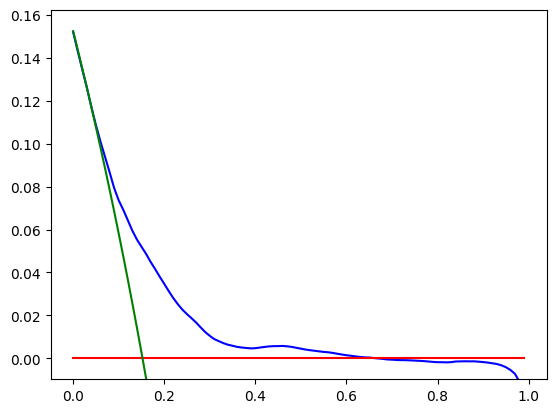

In [303]:
plt.plot(dca_thresholds,dca_curve_cv_missforest_imp.mean(),color = 'blue')
plt.plot(dca_thresholds,tnone_curve, color = 'red')
plt.plot(dca_thresholds,tall_curve, color = 'green')
plt.ylim(dca_curve[99]-0.01, dca_curve[0]+0.01);

The results are again fairly similar to other imputation techniques, although to be fair, we observe another marginal improvement. 

## Regression Imputation (via chained equation) <a class="anchor" id="mice"></a>

The last imputation we will mention here is the multivariate regression-based imputation. The approach initializes imputation with randomly generated values. Then, the variables are imputed one at a time (using the rest of the data via methods like linear regression/predictive mean matching for continuous variables and logistic regression for binary variables). Once all variables are imputed, the process is iteratively repeated, creating a Markov random process. It is assumed that this process will have a unique stationary distribution (which often seems to be the case for real-world data), i.e., the distribution of our imputed values will not depend on the initial selection of the imputed values if enough iterations are taken [[2](#2)].

Imputation via chained equation is primarily implemented in R in the package *mice*. We described how to set this imputation up in a greater detail in The Second Circle: Logistic Regression, Part Two (it is quite a bit more involved than MissForrest, because we have to specify all imputation models and we have to make sure that the resulting Markov random process converges to a stationary distribution). 

Lastly, we should note that *mice* is focused chiefly on inference. It can be shown that chained equation-based imputation provides unbiased regression estimates under missing at random (MAR) conditions (i.e., missingness depends on the observed data), provided that the imputation models are correctly specified and the chained equations converge to a unique stationary distribution. There is also a so-called congeniality condition, which is essentially about the compatibility of the imputation model with the models used for later analysis. In addition, imputation is usually performed *multiple times* (i.e., creating multiple imputed datasets), and the results are pooled together via the so-called Rubin's rules or bootstrap. It can be shown that under correct specification and congeniality, the standard error estimates are also unbiased, resulting in a valid statistical inference [[18](#18)]. 

On the other hand, obtaining predictions is quite a bit clunky (*mice* does not even have a *predict* function). We discuss this in more detail in The Second Circle: Logistic Regression, Part Three.

## References <a class="anchor" id="references"></a>

<a id="1">[1]</a> HARRELL, Frank E., Jr. *Regression Modeling Strategies With Applications to Linear Models, Logistic and Ordinal Regression, and Survival Analysis*. Springer, 2015.

<a id="2">[2]</a> VAN BUUREN, Stef; VAN BUUREN, Stef. *Flexible imputation of missing data*. Boca Raton, FL: CRC press, 2012.

<a id="3">[3]</a> MCEVOY, John William, et al. 2024 ESC Guidelines for the management of elevated blood pressure and hypertension: Developed by the task force on the management of elevated blood pressure and hypertension of the European Society of Cardiology (ESC) and endorsed by the European Society of Endocrinology (ESE) and the European Stroke Organisation (ESO). European heart journal, 2024, 45.38: 3912-4018.

<a id="4">[4]</a> MOOD, Carina. Logistic regression: Why we cannot do what we think we can do, and what we can do about it. *European sociological review*, 2010, 26.1: 67-82.

<a id="5">[5]</a> DUNN, Peter K., et al. Generalized linear models with examples in R. *New York: Springer*, 2018.

<a id="6">[6]</a> VAN HOUWELINGEN, J. C.; LE CESSIE, Saskia. Predictive value of statistical models. *Statistics in medicine*, 1990, 9.11: 1303-1325.

<a id="7">[7]</a> COOK, Nancy R. Use and misuse of the receiver operating characteristic curve in risk prediction. *Circulation*, 2007, 115.7: 928-935.

<a id="8">[8]</a> BURNHAM, Kenneth P.; ANDERSON, David R. Practical use of the information-theoretic approach. In: *Model selection and inference: A practical information-theoretic approach.* New York, NY: Springer New York, 1998. p. 75-117.

<a id="9">[9]</a> HOESSLY, Linard. On misconceptions about the Brier score in binary prediction models. arXiv preprint arXiv:2504.04906, 2025.

<a id="10">[10]</a> VICKERS, Andrew J.; ELKIN, Elena B. Decision curve analysis: a novel method for evaluating prediction models. *Medical Decision Making*, 2006, 26.6: 565-574.

<a id="11">[11]</a> HALL, Peter; WILSON, Susan R. Two guidelines for bootstrap hypothesis testing. Biometrics, 1991, 757-762.

<a id="12">[12]</a> SEU, Kimseth; KANG, Mi-Sun; LEE, HwaMin. An intelligent missing data imputation techniques: A review. *JOIV: International Journal on Informatics Visualization*, 2022, 6.1-2: 278-283.

<a id="13">[13]</a> ALWATEER, Majed, et al. Missing data imputation: A comprehensive review. *Journal of Computer and Communications*, 2024, 12.11: 53-75.

<a id="14">[14]</a>  STEKHOVEN, Daniel J.; BÜHLMANN, Peter. MissForest—non-parametric missing value imputation for mixed-type data. *Bioinformatics*, 2012, 28.1: 112-118.

<a id="15">[15]</a> JADHAV, Anil; PRAMOD, Dhanya; RAMANATHAN, Krishnan. Comparison of performance of data imputation methods for numeric dataset. Applied Artificial Intelligence, 2019, 33.10: 913-933.

<a id="16">[16]</a>  SUN, Yige, et al. Deep learning versus conventional methods for missing data imputation: A review and comparative study. Expert Systems with Applications, 2023, 227: 120201.

<a id="17">[17]</a> JOEL, Luke Oluwaseye; DOORSAMY, Wesley; PAUL, Babu Sena. A comparative study of imputation techniques for missing values in healthcare diagnostic datasets. International Journal of Data Science and Analytics, 2025, 1-17.

<a id="18">[18]</a> MURRAY, Jared S. Multiple imputation: a review of practical and theoretical findings. 2018.